# C3: Bag of Visual Words (BoVW) classification

## Team 7
* Marco Cordón
* Iñaki Lacunza
* Cristian Gutiérrez

## Table of Contents
* Read train and test files
* Test different amounts of local features (KAZE, AKAZE, SIFT, Brisk)
    * Metrics Benchmark (Accuracy, F1, Recall, Precision)
    * Dimensionality Reduction (PCA, LDA)
    * Test Accuracy & Cross-validation Benchmark
* Dense SIFT
    * Dense SIFT Hyper-parameters Fine-tuning
    * Dimensionality Reduction (PCA, LDA)
    * Different scales (1x, 2x, 3x, 4x)
    * Feature Normalization (StandardScaler, MinMaxScaler, Normalize)
* Clustering
    * k-Means Codebook Fine-tuning
    * Dimensionality Reduction (PCA, LDA)
    * Test Accuracy & Cross-validation Benchmark
* Classification (k-NN & SVM)
    * k-NN n_Neighbors Fine-tuning
    * k-NN Different metrics (Euclidean, Cosine, Jaccard)
    * SVM Kernels Fine-tune (Linear, RBF, Histogram Intersection w/ pre-computed method)
    * SVM Dimensionality Reduction (PCA, LDA)
    * k-NN vs SVM Test Accuracy & Cross-validation Benchmark
* PCA & LDA Fine-tune
* Cross-validation
* Spatial Pyramids (up to 4 levels)
* ROC Curve
* Precision-Recall Curve
* Fisher Vectors
* Results Visualization

In [152]:
import fisher as fv # https://gist.github.com/danoneata/9927923/
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn
import pickle
import optuna
import random
import math
import cv2

from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn import svm 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import chain

%config InlineBackend.figure_format = 'retina' # show plots in a better resolution dots per inch

### Read train and test files

In [2]:
train_images_filenames = pickle.load(open('./MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('./MIT_split/test_images_filenames.dat','rb'))
train_images_filenames = ['.' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['.' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('./MIT_split/train_labels.dat','rb')) 
test_labels = pickle.load(open('./MIT_split/test_labels.dat','rb'))

"""
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb')) 
test_labels = pickle.load(open('test_labels.dat','rb'))
"""

"\ntrain_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))\ntest_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))\ntrain_images_filenames = ['..' + n[15:] for n in train_images_filenames]\ntest_images_filenames  = ['..' + n[15:] for n in test_images_filenames]\ntrain_labels = pickle.load(open('train_labels.dat','rb')) \ntest_labels = pickle.load(open('test_labels.dat','rb'))\n"

### Test different amounts of local features

<u>Local features used</u>:

- Kaze
- AKAZE
- SIFT
- BRISK

We have tested different local descriptors methods provided by the OpenCV library. We will make a generic function for a common pipeline, each of them will perform the same steps, with the **default parameters** and later on we will do a small benchmark as a comparison.

<u>Helper functions</u> 

`compute_descriptors`: Will go through all the filenames and compute the descriptors.

`predict_BoVW`: Apply prediction and bincount.

In [3]:
def compute_descriptors(detector,filenames=train_images_filenames, labels=train_labels):
    descriptors = []
    labels_per_desc = []
    for filename,label in zip(filenames,labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=detector.detectAndCompute(gray,None)   
        descriptors.append(des)
        labels_per_desc.append(labels)
    return descriptors, labels_per_desc

def predict_BoVW(codebook, descriptors, k_=128):
    visual_words=np.zeros((len(descriptors), k_), dtype=np.float32)
    for i in range(len(descriptors)):
        words=codebook.predict(descriptors[i])
        visual_words[i,:]=np.bincount(words, minlength=k_)
    return visual_words
    

#### KAZE Local Features

In [8]:
# Compute descriptors train & test
Detector_KAZE = cv2.KAZE_create(threshold=0.0001)
Train_descriptors_KAZE, Train_label_per_descriptor_KAZE = compute_descriptors(Detector_KAZE)
Test_descriptors_KAZE, Test_label_per_descriptor_KAZE = compute_descriptors(Detector_KAZE, test_images_filenames, test_labels)

# Clustering (n_clusters = k) of the feature space
k = 128
codebook_KAZE = MiniBatchKMeans(n_init=3, n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook_KAZE.fit(np.vstack(Train_descriptors_KAZE))

# BoVW train & test
Train_visual_words_KAZE = predict_BoVW(codebook_KAZE, Train_descriptors_KAZE, k_=k)
Test_visual_words_KAZE = predict_BoVW(codebook_KAZE, Test_descriptors_KAZE, k_=k)

# Classifier (kNN)
knn_KAZE = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn_KAZE.fit(Train_visual_words_KAZE, train_labels) 

# Score
accuracy_KAZE = 100*knn_KAZE.score(Test_visual_words_KAZE, test_labels)
print(accuracy_KAZE)


56.753407682775716


#### AKAZE Local Features

In [9]:
# Compute descriptors train & test
Detector_AKAZE = cv2.AKAZE_create(threshold=0.0001)
Train_descriptors_AKAZE, Train_label_per_descriptor_AKAZE = compute_descriptors(Detector_AKAZE)
Test_descriptors_AKAZE, Test_label_per_descriptor_AKAZE = compute_descriptors(Detector_AKAZE, test_images_filenames, test_labels)

# Clustering (n_clusters = k) of the feature space
k = 128
codebook_AKAZE = MiniBatchKMeans(n_init=3, n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook_AKAZE.fit(np.vstack(Train_descriptors_AKAZE))

# BoVW train & test
Train_visual_words_AKAZE = predict_BoVW(codebook_AKAZE, Train_descriptors_AKAZE, k_=k)
Test_visual_words_AKAZE = predict_BoVW(codebook_AKAZE, Test_descriptors_AKAZE, k_=k)

# Classifier (kNN)
knn_AKAZE = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn_AKAZE.fit(Train_visual_words_AKAZE, train_labels) 

# Score
accuracy_AKAZE = 100*knn_AKAZE.score(Test_visual_words_AKAZE, test_labels)
print(accuracy_AKAZE)


46.468401486988846


#### SIFT Local Features

In [10]:
# Compute descriptors train & test
Detector_SIFT = cv2.SIFT_create()
Train_descriptors_SIFT, Train_label_per_descriptor_SIFT = compute_descriptors(Detector_SIFT)
Test_descriptors_SIFT, Test_label_per_descriptor_SIFT = compute_descriptors(Detector_SIFT, test_images_filenames, test_labels)

# Clustering (n_clusters = k) of the feature space
k = 128
codebook_SIFT = MiniBatchKMeans(n_init=3, n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook_SIFT.fit(np.vstack(Train_descriptors_SIFT))

# BoVW train & test
Train_visual_words_SIFT = predict_BoVW(codebook_SIFT, Train_descriptors_SIFT, k_=k)
Test_visual_words_SIFT = predict_BoVW(codebook_SIFT, Test_descriptors_SIFT, k_=k)

# Classifier (kNN)
knn_SIFT = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn_SIFT.fit(Train_visual_words_SIFT, train_labels) 

# Score
accuracy_SIFT = 100*knn_SIFT.score(Test_visual_words_SIFT, test_labels)
print(accuracy_SIFT)


57.99256505576208


#### BRISK Local Features

In [11]:
# Compute descriptors train & test
Detector_BRISK = cv2.BRISK_create()
Train_descriptors_BRISK, Train_label_per_descriptor_BRISK = compute_descriptors(Detector_BRISK)
Test_descriptors_BRISK, Test_label_per_descriptor_BRISK = compute_descriptors(Detector_BRISK, test_images_filenames, test_labels)

# Replace 'None' elements for numpy support
for i in range(len(Train_descriptors_BRISK)):
    if Train_descriptors_BRISK[i] is not None:
        continue
    else:
        Train_descriptors_BRISK[i] = np.zeros((1, 64))

for i in range(len(Test_descriptors_BRISK)):
    if Test_descriptors_BRISK[i] is not None:
        continue
    else:
        Test_descriptors_BRISK[i] = np.zeros((1, 64))

# Clustering (n_clusters = k) of the feature space
k = 128
codebook_BRISK = MiniBatchKMeans(n_init=3, n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook_BRISK.fit(np.vstack(Train_descriptors_BRISK))

# BoVW train & test
Train_visual_words_BRISK = predict_BoVW(codebook_BRISK, Train_descriptors_BRISK, k_=k)
Test_visual_words_BRISK = predict_BoVW(codebook_BRISK, Test_descriptors_BRISK, k_=k)

# Classifier (kNN)
knn_BRISK = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn_BRISK.fit(Train_visual_words_BRISK, train_labels) 

# Score
accuracy_BRISK = 100*knn_BRISK.score(Test_visual_words_BRISK, test_labels)
print(accuracy_BRISK)


47.33581164807931


#### Metrics: Accuracy, F1-score, Recall, Precision

In [4]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def get_metrics_clf(predicted_labels, test_labels, title=""):
    accuracy = round(accuracy_score(test_labels, predicted_labels) * 100, 2)
    f1 = round(f1_score(test_labels, predicted_labels, average='weighted') * 100, 2)
    recall = round(recall_score(test_labels, predicted_labels, average='weighted') * 100, 2)
    precision = round(precision_score(test_labels, predicted_labels, average='weighted') * 100, 2)

    metrics_data = {
        'Accuracy': [accuracy],
        'F1 Score': [f1],
        'Recall': [recall],
        'Precision': [precision]
    }
    
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df['Method'] = title
    
    return metrics_df

In [9]:
predicted_KAZE = knn_KAZE.predict(Test_visual_words_KAZE)
kaze_metrics_df = get_metrics_clf(predicted_KAZE, test_labels, title='Default KAZE')

predicted_AKAZE = knn_AKAZE.predict(Test_visual_words_AKAZE)
akaze_metrics_df = get_metrics_clf(predicted_AKAZE, test_labels, title='Default AKAZE')

predicted_SIFT = knn_SIFT.predict(Test_visual_words_SIFT)
sift_metrics_df = get_metrics_clf(predicted_SIFT, test_labels, title='Default SIFT')

predicted_BRISK = knn_BRISK.predict(Test_visual_words_BRISK)
brisk_metrics_df = get_metrics_clf(predicted_BRISK, test_labels, title='Default BRISK')

combined_metrics_df = pd.concat([kaze_metrics_df, akaze_metrics_df, sift_metrics_df, brisk_metrics_df], ignore_index=True)
combined_metrics_df.set_index('Method', inplace=True)
combined_metrics_df.index.name = None
combined_metrics_df


,Accuracy,F1 Score,Recall,Precision
Default KAZE,56.88,56.04,56.88,57.06
Default AKAZE,47.46,46.46,47.46,47.54
Default SIFT,59.11,58.96,59.11,61.76
Default BRISK,47.21,46.65,47.21,48.35


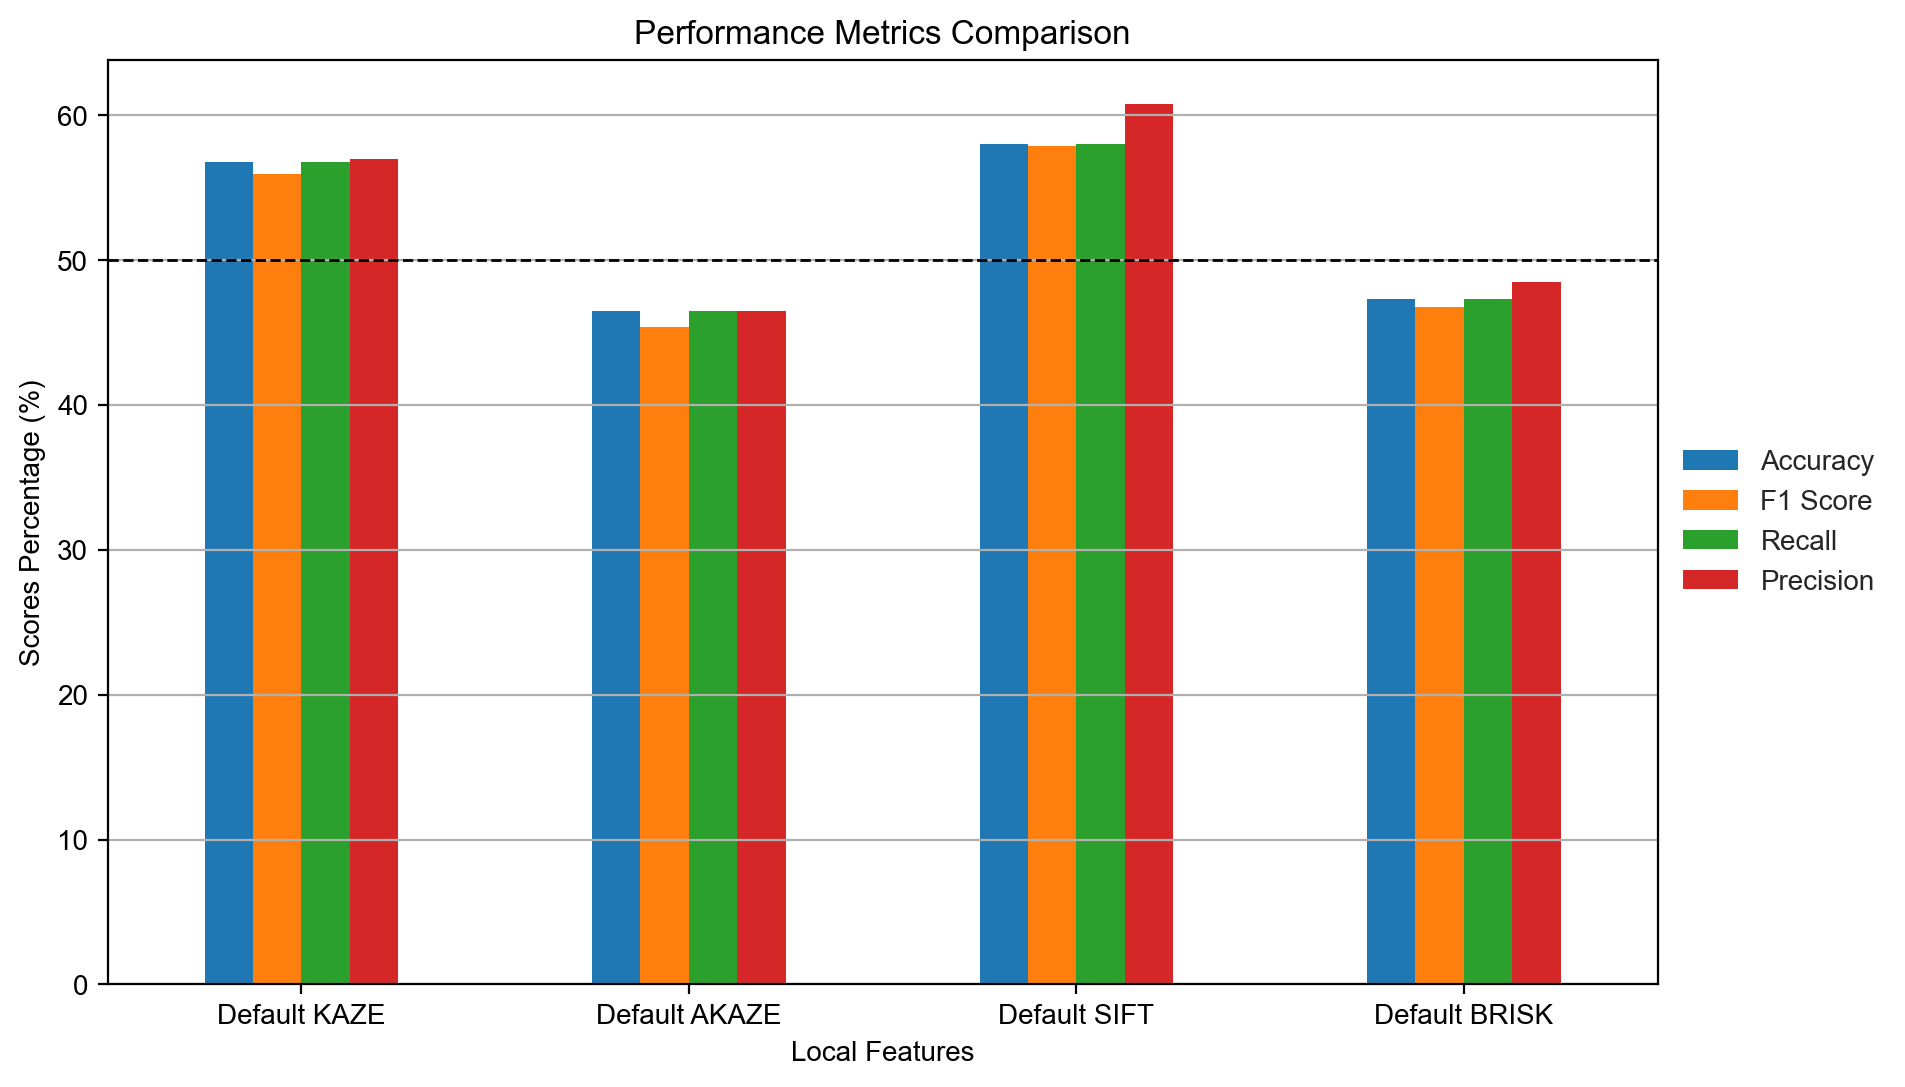

In [24]:
combined_metrics_df.plot(kind='bar', figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)
plt.title('Performance Metrics Comparison')
plt.ylabel('Scores Percentage (%)')
plt.xlabel('Local Features')
plt.xticks(rotation=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='y')
plt.show()


KAZE and SIFT are better than chance (> 50%).

### Dimensionality Reduction (PCA, LDA)

In [5]:
def PCA_reduction(n_components, visual_words_train, visual_words_test, train_labels, test_labels):
    pca_ = PCA(n_components=64)
    VWpca_ = pca_.fit_transform(visual_words_train)
    knnpca_ = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnpca_.fit(VWpca_, train_labels) 
    vwtestpca_ = pca_.transform(visual_words_test)
    return round(knnpca_.score(vwtestpca_, test_labels) * 100, 2), knnpca_, pca_

def LDA_reduction(n_components, visual_words_train, visual_words_test, train_labels, test_labels):
    lda_ = LinearDiscriminantAnalysis(n_components=7)
    VWlda_ = lda_.fit_transform(visual_words_train, train_labels)
    knnlda_ = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnlda_.fit(VWlda_, train_labels) 
    vwtestlda_ = lda_.transform(visual_words_test)
    return round(knnlda_.score(vwtestlda_, test_labels) * 100, 2), knnlda_, lda_

In [13]:
n_components_pca = 69
n_components_lda = 7 # test labels max

# KAZE
accuracy_KAZE_pca, knn_KAZE_pca, pca_KAZE = PCA_reduction(n_components_pca, Train_visual_words_KAZE, Test_visual_words_KAZE, train_labels, test_labels)
accuracy_KAZE_lda, knn_KAZE_lda, lda_KAZE = LDA_reduction(n_components_lda, Train_visual_words_KAZE, Test_visual_words_KAZE, train_labels, test_labels)

# AKAZE
accuracy_AKAZE_pca, knn_AKAZE_pca, pca_AKAZE = PCA_reduction(n_components_pca, Train_visual_words_AKAZE, Test_visual_words_AKAZE, train_labels, test_labels)
accuracy_AKAZE_lda, knn_AKAZE_lda, lda_AKAZE = LDA_reduction(n_components_lda, Train_visual_words_AKAZE, Test_visual_words_AKAZE, train_labels, test_labels)

# SIFT
accuracy_SIFT_pca, knn_SIFT_pca, pca_SIFT = PCA_reduction(n_components_pca, Train_visual_words_SIFT, Test_visual_words_SIFT, train_labels, test_labels)
accuracy_SIFT_lda, knn_SIFT_lda, lda_SIFT = LDA_reduction(n_components_lda, Train_visual_words_SIFT, Test_visual_words_SIFT, train_labels, test_labels)

# BRISK
accuracy_BRISK_pca, knn_BRISK_pca, pca_BRISK = PCA_reduction(n_components_pca, Train_visual_words_BRISK, Test_visual_words_BRISK, train_labels, test_labels)
accuracy_BRISK_lda, knn_BRISK_lda, lda_BRISK = LDA_reduction(n_components_lda, Train_visual_words_BRISK, Test_visual_words_BRISK, train_labels, test_labels)


Principal Component Analysis (PCA) with 69 components works well on both KAZE and slightly better on AKAZE, on the others the result of applying PCA are not as expected.

Linear Discriminant Analisys (LDA) with a fixed parameter of 7 classes (max num. of labels in our dataset) increases much our accuracy on KAZE, AKAZE and SIFT, making AKAZE better than chance. But fails to deliver good results on BRISK.

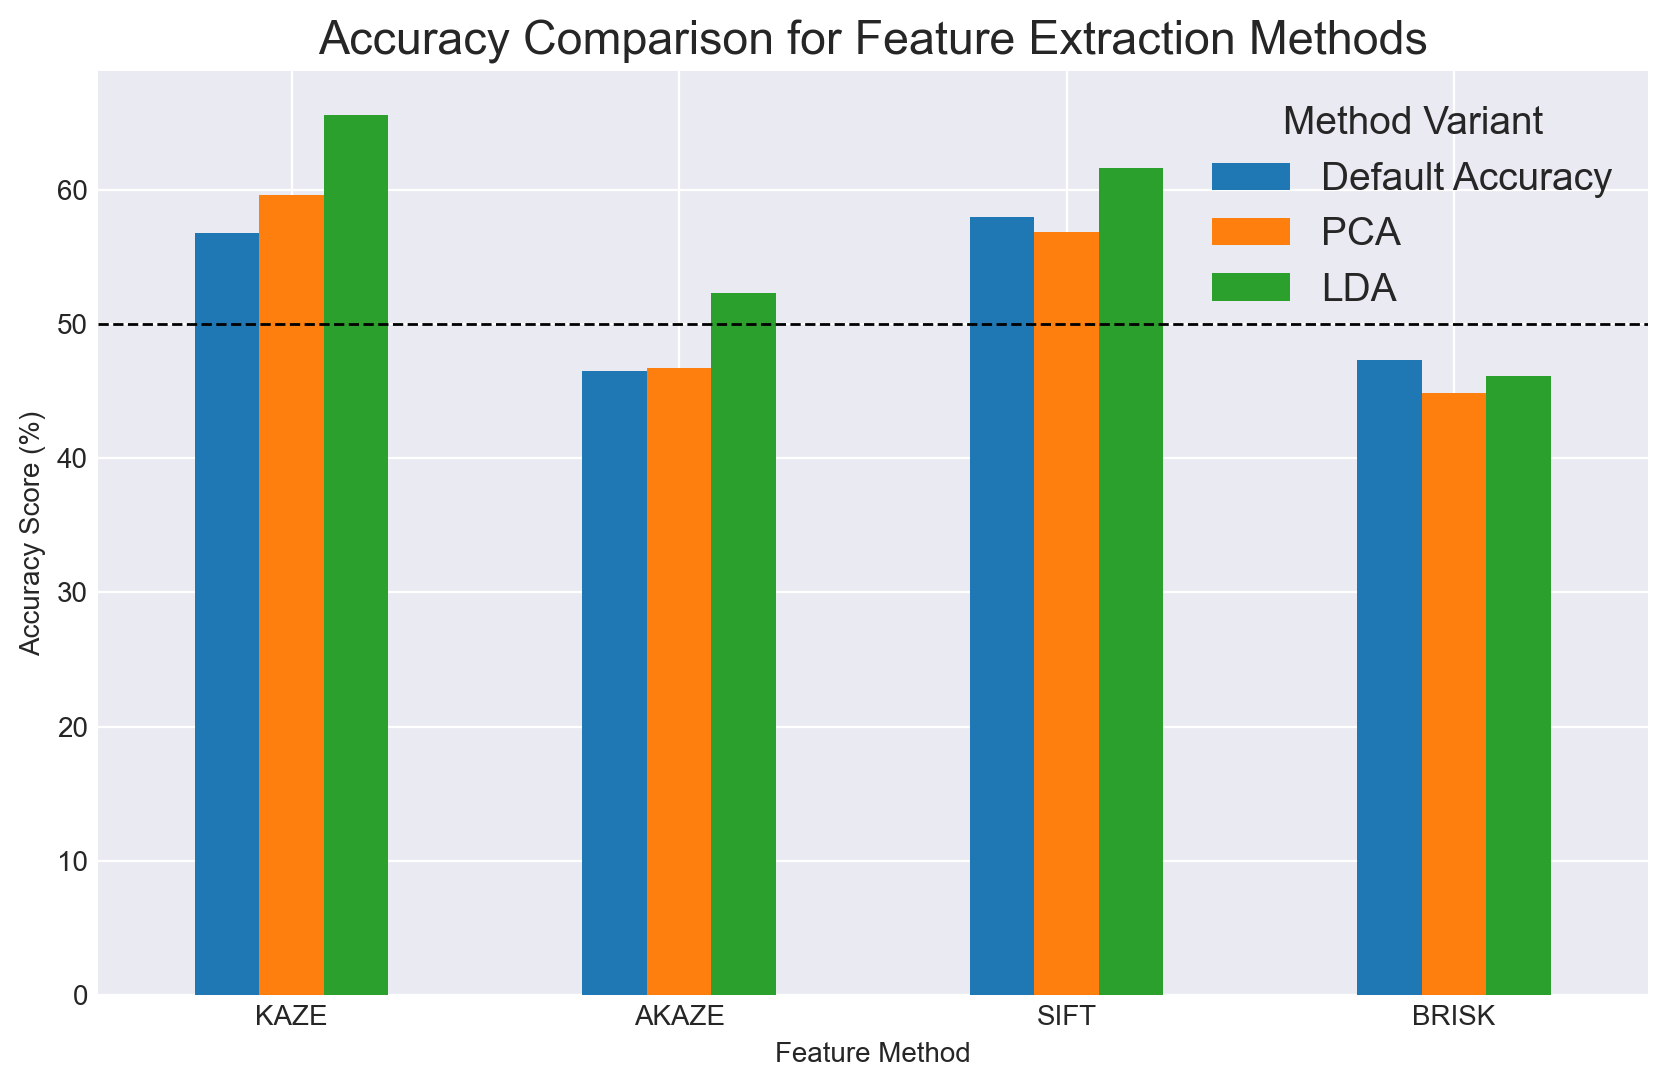

In [27]:
data = {
    'Method': ['KAZE', 'AKAZE', 'SIFT', 'BRISK'],
    'Default Accuracy': [accuracy_KAZE, accuracy_AKAZE, accuracy_SIFT, accuracy_BRISK],
    'PCA': [accuracy_KAZE_pca, accuracy_AKAZE_pca, accuracy_SIFT_pca, accuracy_BRISK_pca],
    'LDA': [accuracy_KAZE_lda, accuracy_AKAZE_lda, accuracy_SIFT_lda, accuracy_BRISK_lda]
}

accuracy_df = pd.DataFrame(data)
plt.style.use('seaborn-v0_8-darkgrid')
accuracy_df.set_index('Method').plot(kind='bar', figsize=(10, 6))
plt.rcParams.update({'font.size': 14})
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)
plt.title('Accuracy Comparison for Feature Extraction Methods')
plt.ylabel('Accuracy Score (%)')
plt.xlabel('Feature Method')
plt.xticks(rotation=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(title='Method Variant')
plt.show()

### Cross-Validation Benchmark

We will use the best results obtained in the previous dimensionality reduction benchmark:
* KAZE (w/ LDA)
* AKAZE (w/ LDA)
* SIFT (w/ LDA)
* Brisk

Important to notice that we will perform cross-validation over the entire dataset, but we **keep the models trained only with the training set**.

In [14]:
from sklearn.model_selection import cross_val_score

n_folds = 10

# Merge train and test to get the full dataset
X_filenames = train_images_filenames + test_images_filenames
Y_labels = train_labels + test_labels

# KAZE (w/ LDA)
X_desc_KAZE, _ = compute_descriptors(Detector_KAZE, X_filenames, Y_labels)
VW_KAZE = predict_BoVW(codebook_KAZE, X_desc_KAZE, k_=k)
VW_KAZE_lda = lda_KAZE.transform(VW_KAZE)
accuracies_KAZE = cross_val_score(knn_KAZE_lda, np.vstack(VW_KAZE_lda), Y_labels, cv=n_folds)
print("KAZE Cross-validation accuracy ({} folds): {}".format(n_folds, round(np.mean(accuracies_KAZE) * 100, 2)))

# AKAZE (w/ LDA)
X_desc_AKAZE, _ = compute_descriptors(Detector_AKAZE, X_filenames, Y_labels)
VW_AKAZE = predict_BoVW(codebook_AKAZE, X_desc_AKAZE, k_=k)
VW_AKAZE_lda = lda_AKAZE.transform(VW_AKAZE)
accuracies_AKAZE = cross_val_score(knn_AKAZE_lda, np.vstack(VW_AKAZE_lda), Y_labels, cv=n_folds)
print("AKAZE Cross-validation accuracy ({} folds): {}".format(n_folds, round(np.mean(accuracies_AKAZE) * 100, 2)))

# SIFT (w/ LDA)
X_desc_SIFT, _ = compute_descriptors(Detector_SIFT, X_filenames, Y_labels)
VW_SIFT = predict_BoVW(codebook_SIFT, X_desc_SIFT, k_=k)
VW_SIFT_lda = lda_SIFT.transform(VW_SIFT)
accuracies_SIFT = cross_val_score(knn_SIFT_lda, np.vstack(VW_SIFT_lda), Y_labels, cv=n_folds)
print("SIFT Cross-validation accuracy ({} folds): {}".format(n_folds, round(np.mean(accuracies_SIFT) * 100, 2)))

# BRISK
X_desc_BRISK, _ = compute_descriptors(Detector_BRISK, X_filenames, Y_labels)
# Replace 'None' elements for numpy support
for i in range(len(X_desc_BRISK)):
    if X_desc_BRISK[i] is not None:
        continue
    else:
        X_desc_BRISK[i] = np.zeros((1, 64))
VW_BRISK = predict_BoVW(codebook_BRISK, X_desc_BRISK, k_=k)
accuracies_BRISK = cross_val_score(knn_BRISK, np.vstack(VW_BRISK), Y_labels, cv=n_folds)
print("BRISK Cross-validation accuracy ({} folds): {}".format(n_folds, round(np.mean(accuracies_BRISK) * 100, 2)))


KAZE Cross-validation accuracy (10 folds): 68.56
AKAZE Cross-validation accuracy (10 folds): 56.77
SIFT Cross-validation accuracy (10 folds): 66.26
BRISK Cross-validation accuracy (10 folds): 44.42


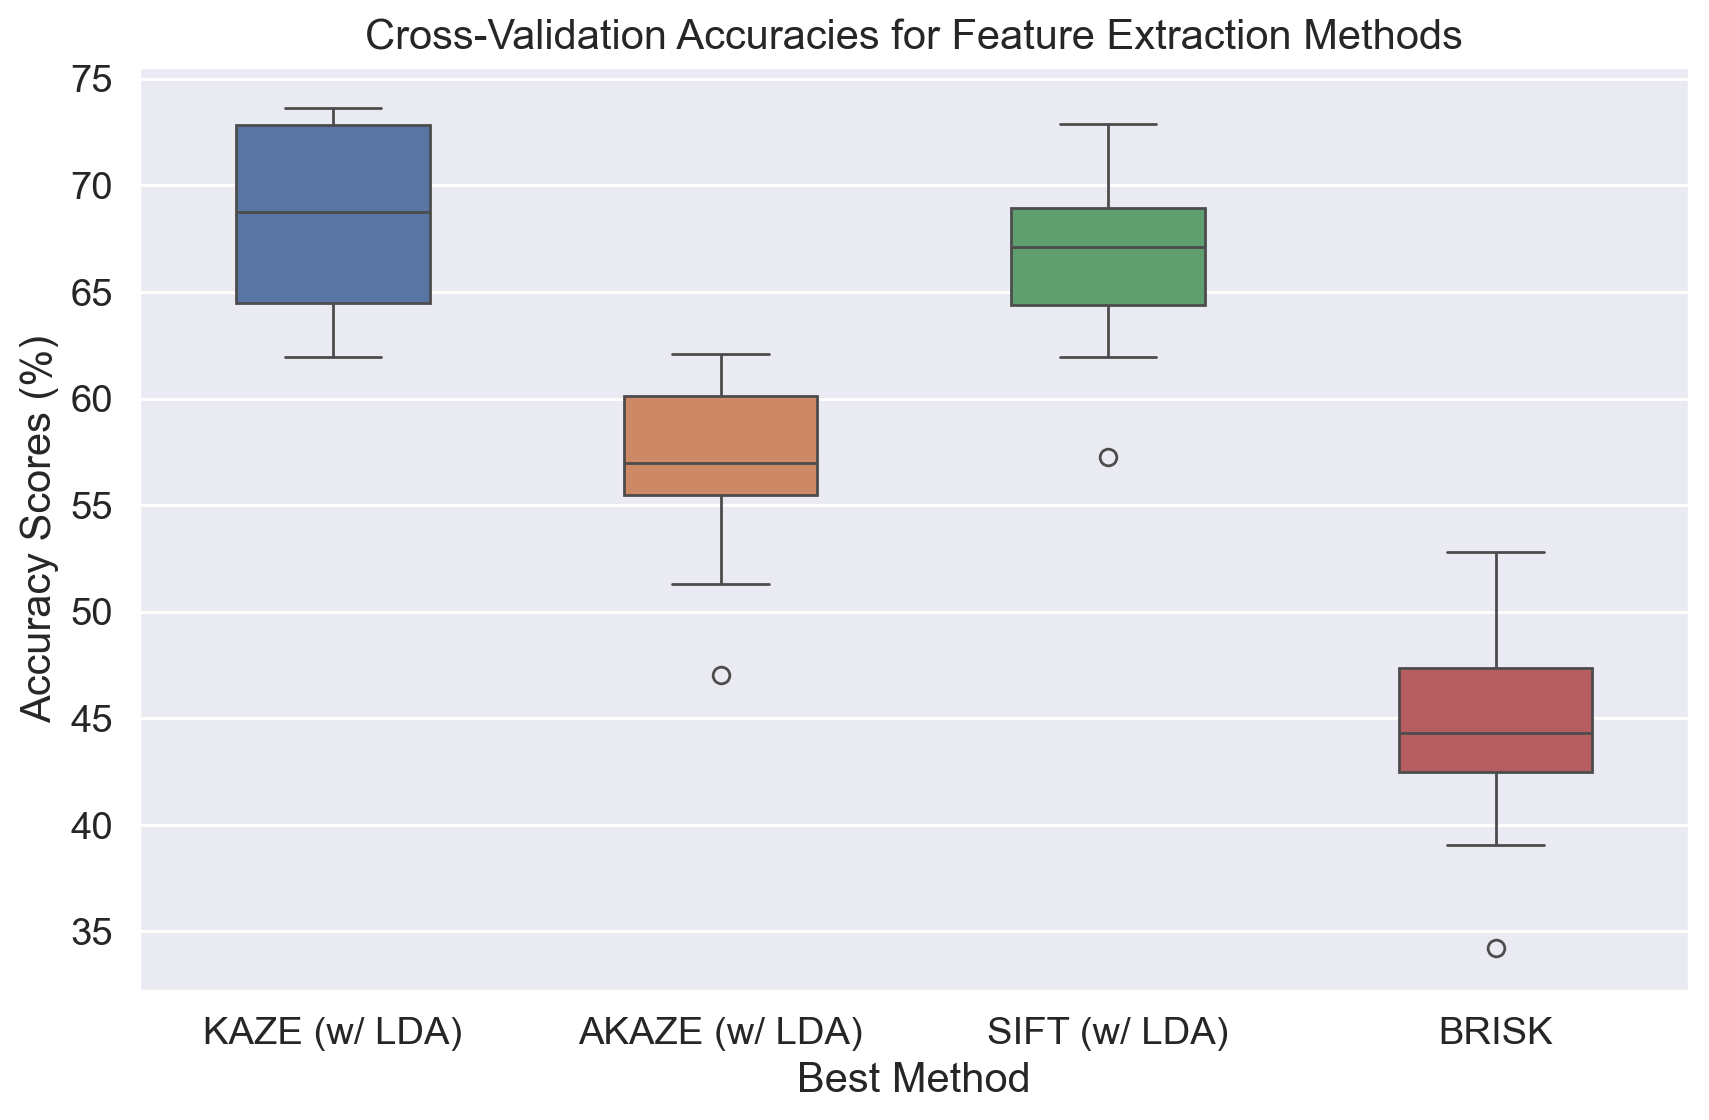

In [29]:

data = {
    'KAZE (w/ LDA)': accuracies_KAZE * 100,
    'AKAZE (w/ LDA)': accuracies_AKAZE * 100,
    'SIFT (w/ LDA)': accuracies_SIFT * 100,
    'BRISK': accuracies_BRISK * 100
}

accuracy_df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
seaborn.set(font_scale=1.25)
seaborn.boxplot(data=accuracy_df, width=0.5)

plt.title('Cross-Validation Accuracies for Feature Extraction Methods')
plt.ylabel('Accuracy Scores (%)')
plt.xlabel('Best Method')

plt.show()

### Dense SIFT

We can compute SIFT descriptors at consecutive image positions. The gap between two descriptors depends on the step size that we can fix.

In [ ]:
def compute_dense_descriptors(detector, step_size, filenames=train_images_filenames, labels=train_labels, param_scale = None):
    descriptors = []
    labels_per_desc = []
    og_step_size = step_size
    for filename,label in zip(filenames,labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        if param_scale is not None:
            scale_factor = 1 / (2 ** param_scale - 1)
            gray = cv2.resize(gray, None, fx=scale_factor, fy=scale_factor)
            step_size = int(og_step_size / (2 ** param_scale - 1))
            # print("scale_factor {}\t param_scale {}\t step_size{}\t og_step_size".format(scale_factor, param_scale, step_size, og_step_size))
            
        # dense step
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=detector.compute(gray,kp)
        descriptors.append(des)
        labels_per_desc.append(labels)
    
    return descriptors, labels_per_desc

def pipeline_dense_sift(step_size, nfeatures=0, nOctaveLayers=3, cross_val=False, pca=False, lda=False,k_codebook=128,k_neighbors=5,distance='euclidean', param_scale=None):
    # Compute descriptors train & test
    Detector_DENSE_SIFT = cv2.SIFT_create(nfeatures=nfeatures,nOctaveLayers=nOctaveLayers)
    Train_descriptors_DENSE_SIFT, Train_label_per_descriptor_DENSE_SIFT = compute_dense_descriptors(Detector_DENSE_SIFT, step_size, param_scale = param_scale)
    Test_descriptors_DENSE_SIFT, Test_label_per_descriptor_DENSE_SIFT = compute_dense_descriptors(Detector_DENSE_SIFT, step_size, test_images_filenames, test_labels, param_scale = param_scale)
        
    # Clustering (n_clusters = k) of the feature space
    k = k_codebook
    codebook_DENSE_SIFT = MiniBatchKMeans(n_init=3, n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook_DENSE_SIFT.fit(np.vstack(Train_descriptors_DENSE_SIFT))
    
    # BoVW train & test
    Train_visual_words_DENSE_SIFT = predict_BoVW(codebook_DENSE_SIFT, Train_descriptors_DENSE_SIFT, k_=k)
    Test_visual_words_DENSE_SIFT = predict_BoVW(codebook_DENSE_SIFT, Test_descriptors_DENSE_SIFT, k_=k)
    
    if pca:
        pca_ = PCA(n_components=64)
        Train_visual_words_DENSE_SIFT = pca_.fit_transform(Train_visual_words_DENSE_SIFT)
    if lda:
        lda_ = LinearDiscriminantAnalysis(n_components=7)
        Train_visual_words_DENSE_SIFT = lda_.fit_transform(Train_visual_words_DENSE_SIFT, train_labels)
        
    # Classifier (kNN)
    knn_DENSE_SIFT = KNeighborsClassifier(n_neighbors=k_neighbors,n_jobs=-1,metric=distance)
    knn_DENSE_SIFT.fit(Train_visual_words_DENSE_SIFT, train_labels) 
    
    if pca:
        Test_visual_words_DENSE_SIFT = pca_.transform(Test_visual_words_DENSE_SIFT)
    if lda:
        Test_visual_words_DENSE_SIFT = lda_.transform(Test_visual_words_DENSE_SIFT)

    # Test score
    test_acc_DENSE_SIFT = knn_DENSE_SIFT.score(Test_visual_words_DENSE_SIFT, test_labels)

    # Cross-validation score (conditional for performance purposes)
    if cross_val:
        X_DENSE_SIFT = Train_descriptors_DENSE_SIFT + Test_descriptors_DENSE_SIFT
        VW_DENSE_SIFT = np.concatenate([Train_visual_words_DENSE_SIFT, Test_visual_words_DENSE_SIFT], axis=0)
        Y_labels = train_labels + test_labels
    
        crossval_acc_DENSE_SIFT = cross_val_score(knn_DENSE_SIFT, np.vstack(VW_DENSE_SIFT), Y_labels, cv=n_folds)
            
        return 100*test_acc_DENSE_SIFT, 100*crossval_acc_DENSE_SIFT
    
    return 100*test_acc_DENSE_SIFT


We clearly see how by using Dense SIFT we obtain better results. In the case of a random sampled Step size of 10 we obtain an increase in accuracy of **121%** wrt the SIFT with LDA and default params.

In [14]:
print("SIFT (Default params w/ LDA)\t Test Accuracy: {}\t Cross-val: {}".format(accuracy_SIFT_lda, round(np.mean(accuracies_SIFT) * 100, 2))) 

step_size = 10
test_acc_DENSE_SIFT_10, crossval_acc_DENSE_SIFT_10 = pipeline_dense_sift(step_size, cross_val=True)
print("Dense SIFT (step_size = {})\t Test Accuracy: {}\t Cross-val: {}".format(step_size, round(test_acc_DENSE_SIFT_10, 2), round(np.mean(crossval_acc_DENSE_SIFT_10), 2)))

step_size = 5
test_acc_DENSE_SIFT_5, crossval_acc_DENSE_SIFT_5 = pipeline_dense_sift(step_size, cross_val=True)
print("Dense SIFT (step_size = {})\t Test Accuracy: {}\t Cross-val: {}".format(step_size, round(test_acc_DENSE_SIFT_5, 2), round(np.mean(crossval_acc_DENSE_SIFT_5), 2)))


SIFT (Default params w/ LDA)	 Test Accuracy: 62.95	 Cross-val: 65.85
Dense SIFT (step_size = 10)	 Test Accuracy: 7459.73	 Cross-val: 7514.83
Dense SIFT (step_size = 5)	 Test Accuracy: 7087.98	 Cross-val: 7206.11


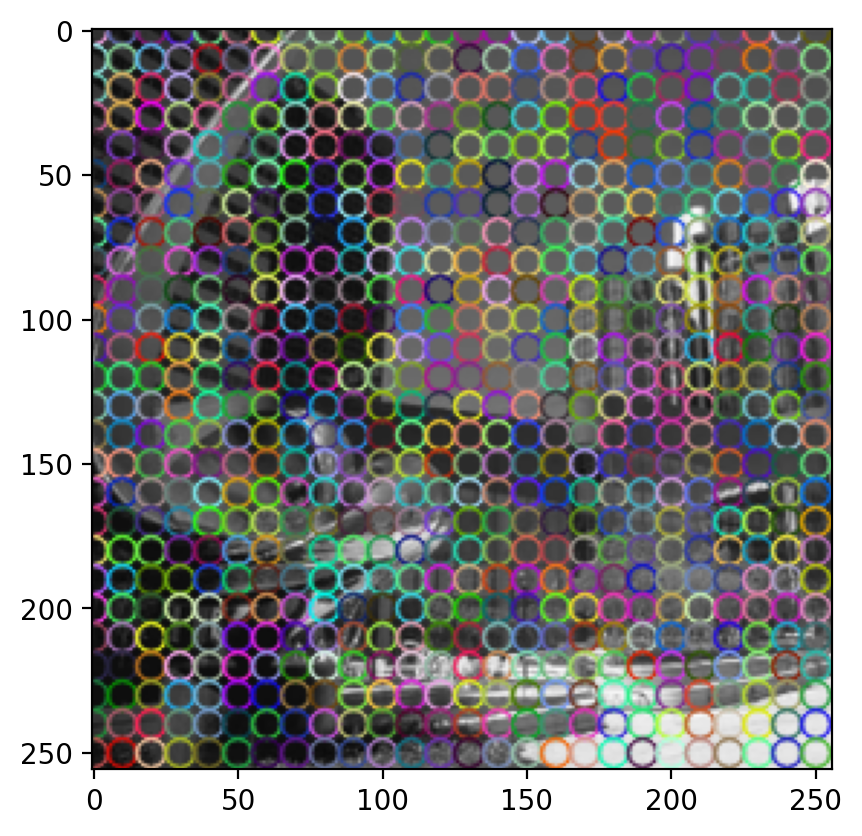

In [22]:
img=cv2.drawKeypoints(gray,kp, ima, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.imshow(img)
plt.show()

#### Dense SIFT Hyperparameters finetuning
We use Optuna library for looking for the best Hyperarameters.

We will proceed to fine-tune the Dense SIFT Hyperparameters, we have the following params:

- `n_Features`
- `n_OctaveLayers`
- `step_size`

In [17]:
# Optuna for the step_size

def obj_stepsize(trial):
    step_size = trial.suggest_int("step_size", 5, 50, log=True)
    test_acc_DENSE_SIFT = pipeline_dense_sift(step_size, cross_val=False)
    return test_acc_DENSE_SIFT
    
study = optuna.create_study(direction = "maximize")
study.optimize(obj_stepsize, n_trials = 20)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-12-24 10:54:09,071] A new study created in memory with name: no-name-99070e0b-030d-4a65-9a5c-4e511146ad70
[I 2023-12-24 10:54:45,186] Trial 0 finished with value: 74.59727385377943 and parameters: {'step_size': 10}. Best is trial 0 with value: 74.59727385377943.
[I 2023-12-24 10:55:15,919] Trial 1 finished with value: 72.73853779429987 and parameters: {'step_size': 29}. Best is trial 0 with value: 74.59727385377943.
[I 2023-12-24 10:55:47,046] Trial 2 finished with value: 65.79925650557621 and parameters: {'step_size': 50}. Best is trial 0 with value: 74.59727385377943.
[I 2023-12-24 10:56:26,560] Trial 3 finished with value: 72.11895910780669 and parameters: {'step_size': 7}. Best is trial 0 with value: 74.59727385377943.
[I 2023-12-24 10:56:53,395] Trial 4 finished with value: 67.7819083023544 and parameters: {'step_size': 44}. Best is trial 0 with value: 74.59727385377943.
[I 2023-12-24 10:57:27,343] Trial 5 finished with value: 76.45600991325898 and parameters: {'step_size'

Best Score:  76.57992565055763
Best Params: 
  step_size: 14


In [16]:
#Optuna for stepsize, nfeatures and nOctave Layers
def obj_stepsize2(trial):
    step_size = trial.suggest_int("step_size", 10, 50, log=True)
    nfeatures = trial.suggest_int("nfeatures", 100, 250, log=True)
    nOctaveLayers = trial.suggest_int("nOctaveLayers", 1, 5, log=True)
    test_acc_DENSE_SIFT = pipeline_dense_sift(step_size,nfeatures,nOctaveLayers,cross_val=False)
    return test_acc_DENSE_SIFT
    
study = optuna.create_study(direction = "maximize")
study.optimize(obj_stepsize2, n_trials = 20)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-12-24 10:43:14,479] A new study created in memory with name: no-name-1fa1434b-ddb9-4bb4-83da-fa55fe13cf6d
[I 2023-12-24 10:43:44,884] Trial 0 finished with value: 65.79925650557621 and parameters: {'step_size': 50, 'nfeatures': 112, 'nOctaveLayers': 1}. Best is trial 0 with value: 65.79925650557621.
[I 2023-12-24 10:44:15,311] Trial 1 finished with value: 74.59727385377943 and parameters: {'step_size': 11, 'nfeatures': 165, 'nOctaveLayers': 2}. Best is trial 1 with value: 74.59727385377943.
[I 2023-12-24 10:44:47,955] Trial 2 finished with value: 76.45600991325898 and parameters: {'step_size': 15, 'nfeatures': 112, 'nOctaveLayers': 3}. Best is trial 2 with value: 76.45600991325898.
[I 2023-12-24 10:45:15,821] Trial 3 finished with value: 65.79925650557621 and parameters: {'step_size': 50, 'nfeatures': 105, 'nOctaveLayers': 3}. Best is trial 2 with value: 76.45600991325898.
[I 2023-12-24 10:45:48,984] Trial 4 finished with value: 76.2081784386617 and parameters: {'step_size': 12

Best Score:  76.95167286245353
Best Params: 
  step_size: 18
  nfeatures: 185
  nOctaveLayers: 2


Our **Fine-tuned Dense SIFT** will contain the following parameters:

- `n_Features = 185`
- `n_OctaveLayers = 2`
- `step_size = 18`

We will also perform Dimensionality Reduction (PCA & LDA) to see how it works:

In [15]:
print("SIFT (Default params w/ LDA)\t Test Accuracy: {}\t Cross-val: {}".format(accuracy_SIFT_lda, round(np.mean(accuracies_SIFT) * 100, 2))) 

# Fine-tuned Dense SIFT
step_size = 18
nfeatures = 185
nOctaveLayers = 2
test_acc_DENSE_SIFT_fine, crossval_acc_DENSE_SIFT_fine = pipeline_dense_sift(step_size, nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, cross_val=True)
print("Dense SIFT (Params. Fine-tuned)\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_fine, 2), round(np.mean(crossval_acc_DENSE_SIFT_fine), 2)))

# Fine-tuned Dense SIFT + PCA
step_size = 18
nfeatures = 185
nOctaveLayers = 2
test_acc_DENSE_SIFT_fine_pca, crossval_acc_DENSE_SIFT_fine_pca = pipeline_dense_sift(step_size, nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, cross_val=True, pca=True)
print("Dense SIFT (Fine-tuned w/ PCA)\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_fine_pca, 2), round(np.mean(crossval_acc_DENSE_SIFT_fine_pca), 2)))

# Fine-tuned Dense SIFT + LDA
step_size = 18
nfeatures = 185
nOctaveLayers = 2
test_acc_DENSE_SIFT_fine_lda, crossval_acc_DENSE_SIFT_fine_lda = pipeline_dense_sift(step_size, nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, cross_val=True, lda=True)
print("Dense SIFT (Fine-tuned w/ LDA)\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_fine_lda, 2), round(np.mean(crossval_acc_DENSE_SIFT_fine_lda), 2)))


SIFT (Default params w/ LDA)	 Test Accuracy: 61.59	 Cross-val: 66.26
Dense SIFT (Params. Fine-tuned)	 Test Accuracy: 76.95	 Cross-val: 76.53
Dense SIFT (Fine-tuned w/ PCA)	 Test Accuracy: 77.08	 Cross-val: 76.01
Dense SIFT (Fine-tuned w/ LDA)	 Test Accuracy: 78.44	 Cross-val: 81.69


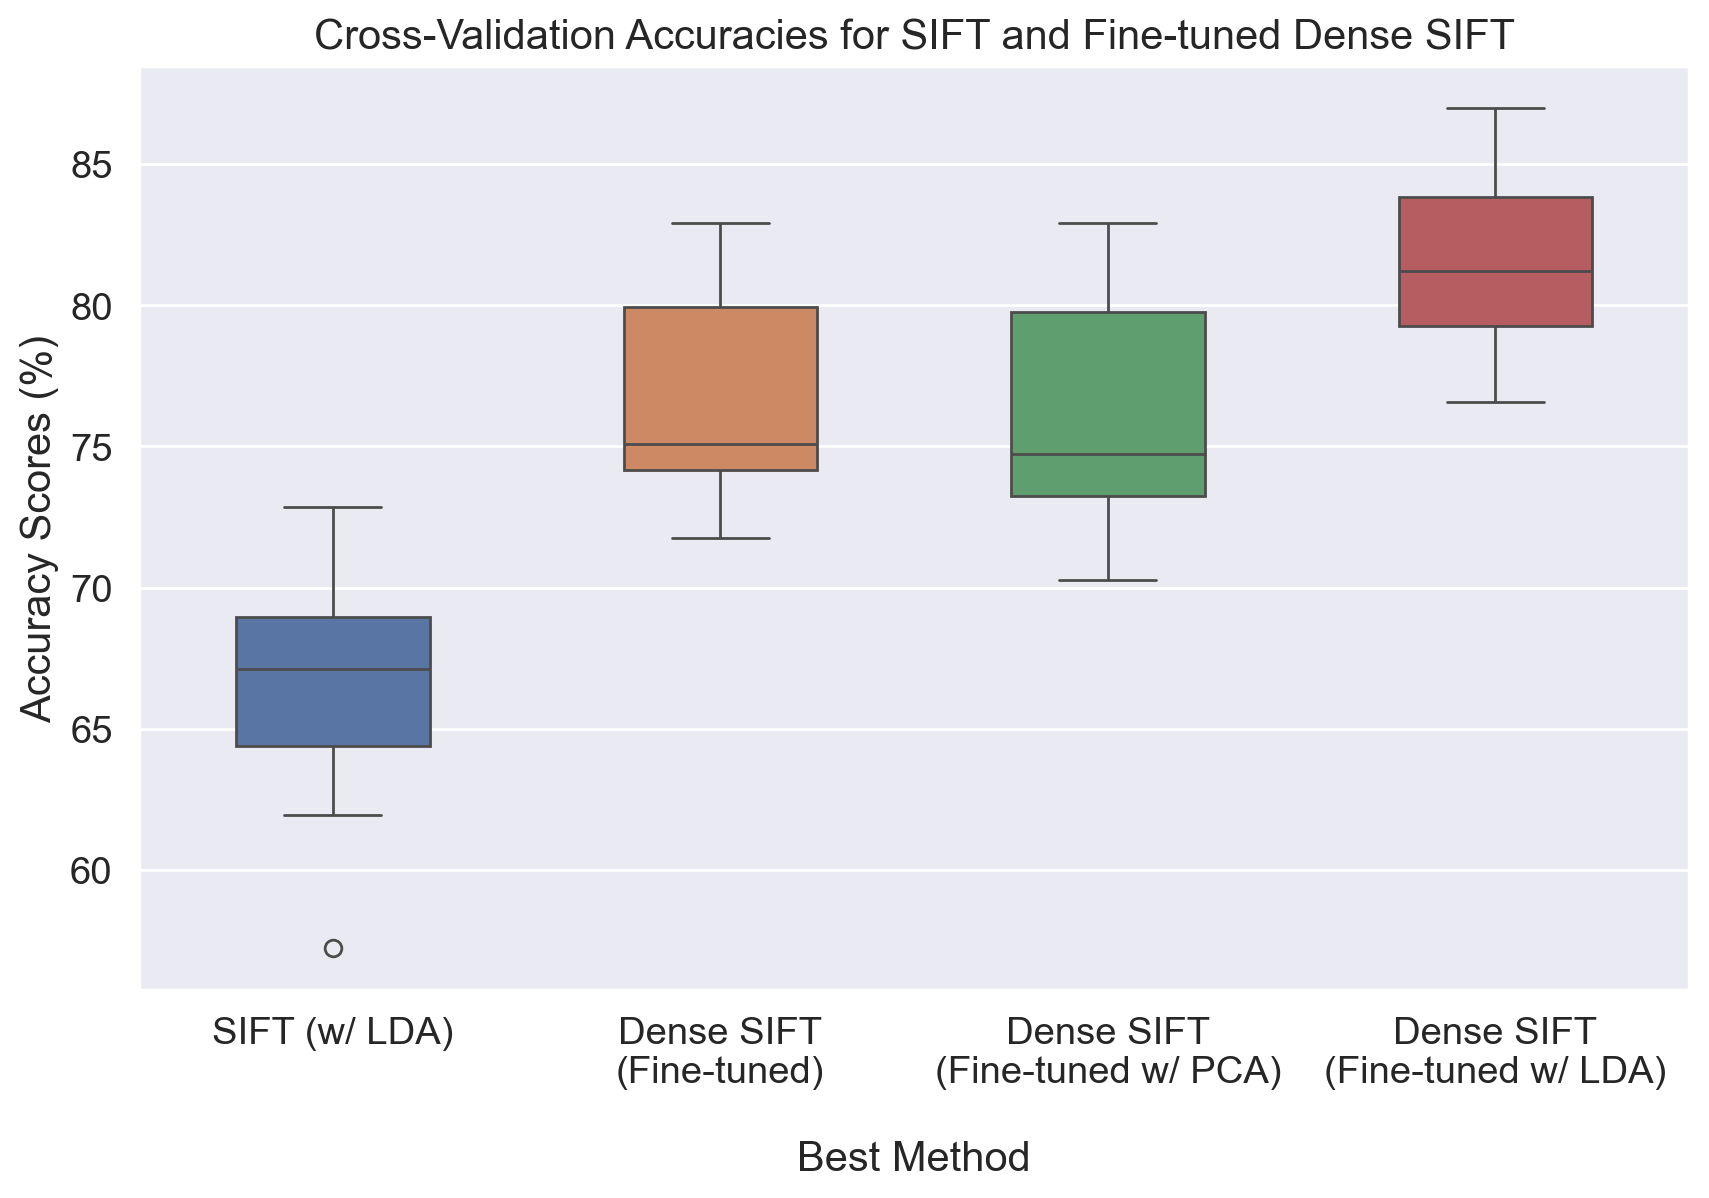

In [16]:

data = {
    'SIFT (w/ LDA)': accuracies_SIFT * 100,
    'Dense SIFT\n(Fine-tuned)': crossval_acc_DENSE_SIFT_fine,
    'Dense SIFT\n(Fine-tuned w/ PCA)': crossval_acc_DENSE_SIFT_fine_pca,
    'Dense SIFT\n(Fine-tuned w/ LDA)\n': crossval_acc_DENSE_SIFT_fine_lda
}

accuracy_df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
seaborn.set(font_scale=1.25)
seaborn.boxplot(data=accuracy_df, width=0.5)

plt.title('Cross-Validation Accuracies for SIFT and Fine-tuned Dense SIFT')
plt.ylabel('Accuracy Scores (%)')
plt.xlabel('Best Method')

plt.show()

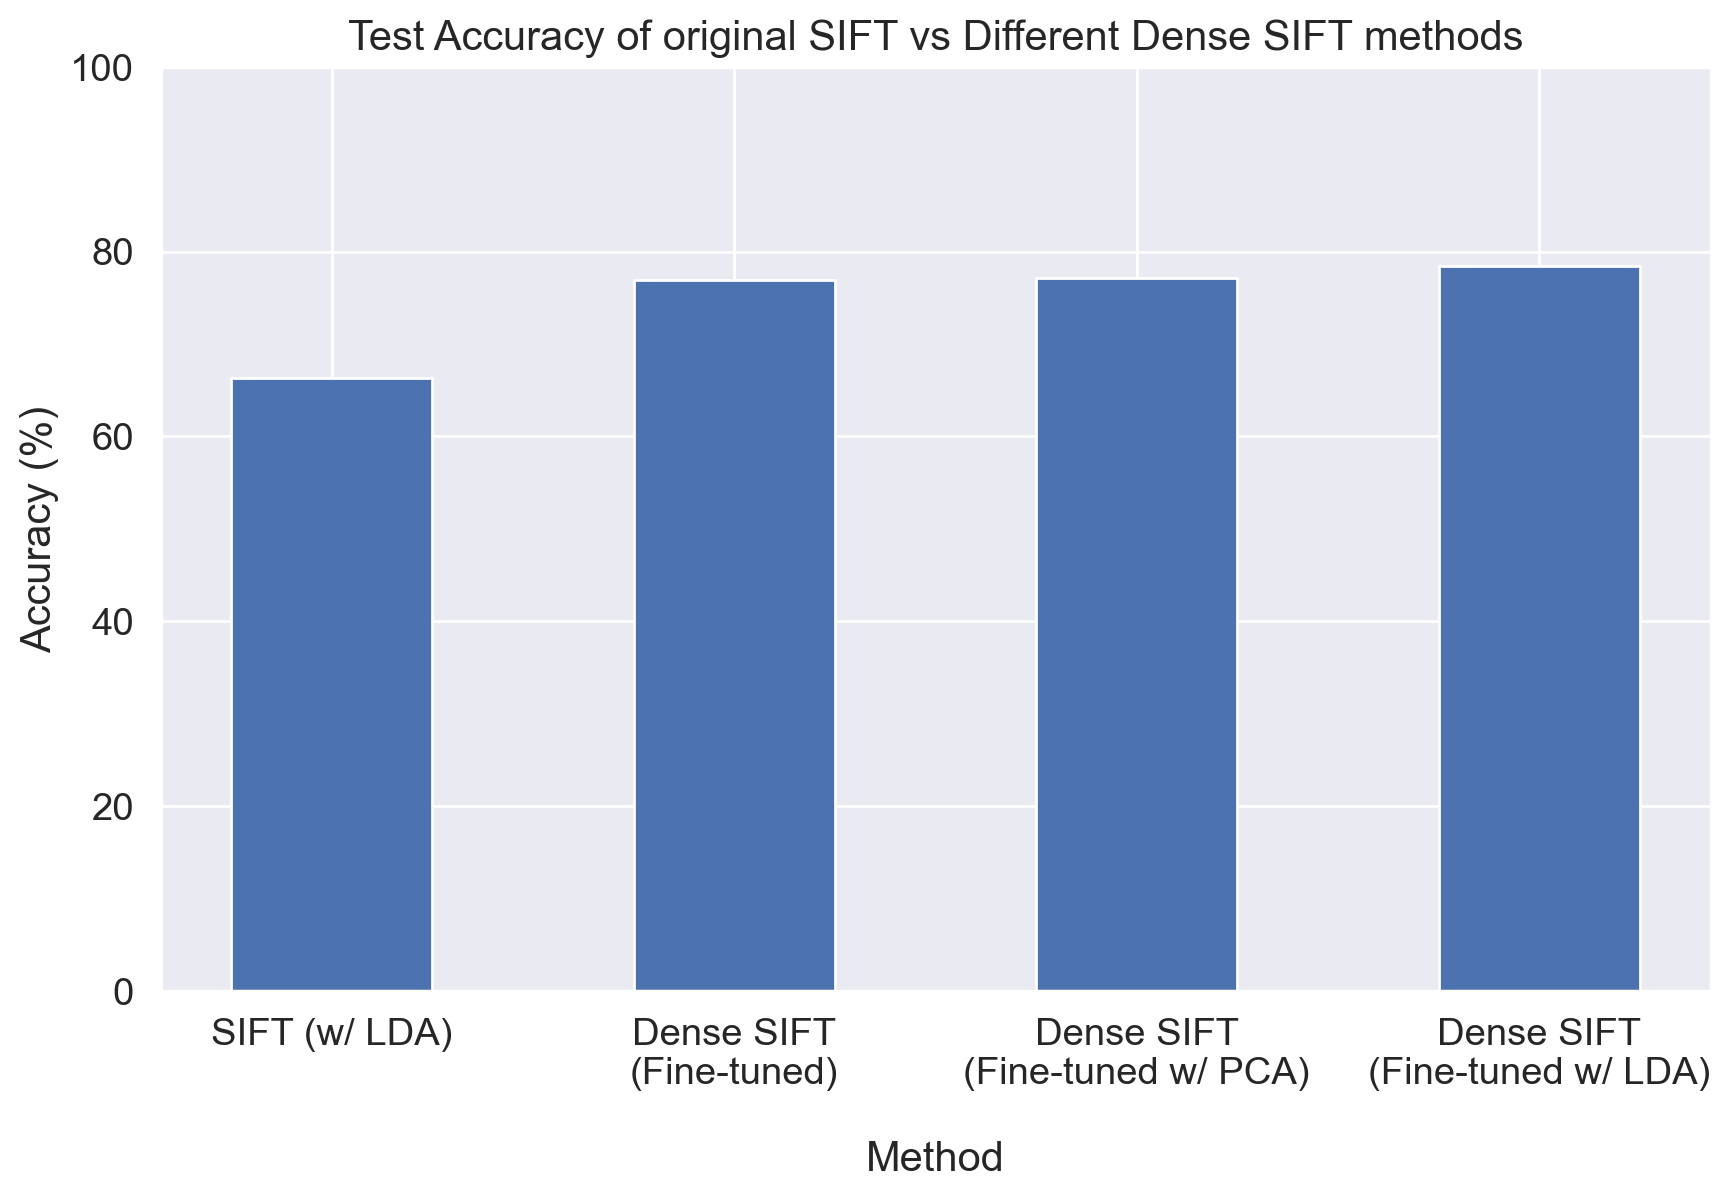

In [17]:
data = {
    'SIFT (w/ LDA)': round(np.mean(accuracies_SIFT) * 100, 2),
    'Dense SIFT\n(Fine-tuned)': round(test_acc_DENSE_SIFT_fine, 2),
    'Dense SIFT\n(Fine-tuned w/ PCA)': round(test_acc_DENSE_SIFT_fine_pca, 2),
    'Dense SIFT\n(Fine-tuned w/ LDA)\n': round(test_acc_DENSE_SIFT_fine_lda, 2)
}

accuracy_df = pd.DataFrame(list(data.items()), columns=['Method', 'Accuracy'])

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Method'], accuracy_df['Accuracy'], width=0.5)
plt.title('Test Accuracy of original SIFT vs Different Dense SIFT methods')
plt.ylabel('Accuracy (%)')
plt.xlabel('Method')
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.show()

### Different scales in Dense SIFT (Fine-tuned)

Now that we have obtained a fine-tuned version with the best parameters of Dense SIFT, we can play with different scales. We will do so by using `x1`, `x2`, `x3` and `x4` scale factors that will:

* Reduce the image by the scale factor by $(2^{Scale})$.
* Adjust the Step size to obtain the same number of descritors by each scale.

The later is a choice done to favour a fair comparison for different scales under the same conditions.

Suppose our Dense SIFT model fine-tuned using Optuna, with an original image of $512\times 512$ with a step size of `18`:

|     | Size of the image  | Step size  | Num. Descriptors  |
|-----|--------------------|------------|-------------------|
|  x1 |   $512\times 512$  | $18$         |  $(512 / 18)^2=809~$ |
|  x2 |   $256\times 256$  | $18/2 = 9$   |  $(256 / 9)^2=809~$  |
|  x4 |   $128\times 128$  | $18/4 = 4.5$   |  $(128 / 4.5)^2=809~$  |

In [8]:
# Dense SIFT Hyperparams. (optuna)
step_size = 18
nfeatures = 185
nOctaveLayers = 2

# Cross-val params
n_folds = 10

# Fine-tuned Dense SIFT (Scale factor 1x)
test_acc_DENSE_SIFT_fine_1x, crossval_acc_DENSE_SIFT_fine_1x = pipeline_dense_sift(step_size, nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, cross_val=True, param_scale=1)
print("[Scale 1x]\tDense SIFT (Params. Fine-tuned)\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_fine_1x, 2), round(np.mean(crossval_acc_DENSE_SIFT_fine_1x), 2)))

# Fine-tuned Dense SIFT (Scale factor 2x)
test_acc_DENSE_SIFT_fine_2x, crossval_acc_DENSE_SIFT_fine_2x = pipeline_dense_sift(step_size, nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, cross_val=True, param_scale=2)
print("[Scale 2x]\tDense SIFT (Params. Fine-tuned)\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_fine_2x, 2), round(np.mean(crossval_acc_DENSE_SIFT_fine_2x), 2)))

# Fine-tuned Dense SIFT (Scale factor 3x)
test_acc_DENSE_SIFT_fine_3x, crossval_acc_DENSE_SIFT_fine_3x = pipeline_dense_sift(step_size, nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, cross_val=True, param_scale=3)
print("[Scale 3x]\tDense SIFT (Params. Fine-tuned)\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_fine_3x, 2), round(np.mean(crossval_acc_DENSE_SIFT_fine_3x), 2)))

# Fine-tuned Dense SIFT (Scale factor 4x)
test_acc_DENSE_SIFT_fine_4x, crossval_acc_DENSE_SIFT_fine_4x = pipeline_dense_sift(step_size, nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, cross_val=True, param_scale=4)
print("[Scale 4x]\tDense SIFT (Params. Fine-tuned)\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_fine_4x, 2), round(np.mean(crossval_acc_DENSE_SIFT_fine_4x), 2)))


[Scale 1x]	Dense SIFT (Params. Fine-tuned)	 Test Accuracy: 76.95	 Cross-val: 76.53
[Scale 2x]	Dense SIFT (Params. Fine-tuned)	 Test Accuracy: 63.44	 Cross-val: 62.72
[Scale 3x]	Dense SIFT (Params. Fine-tuned)	 Test Accuracy: 47.46	 Cross-val: 49.63
[Scale 4x]	Dense SIFT (Params. Fine-tuned)	 Test Accuracy: 36.68	 Cross-val: 36.76


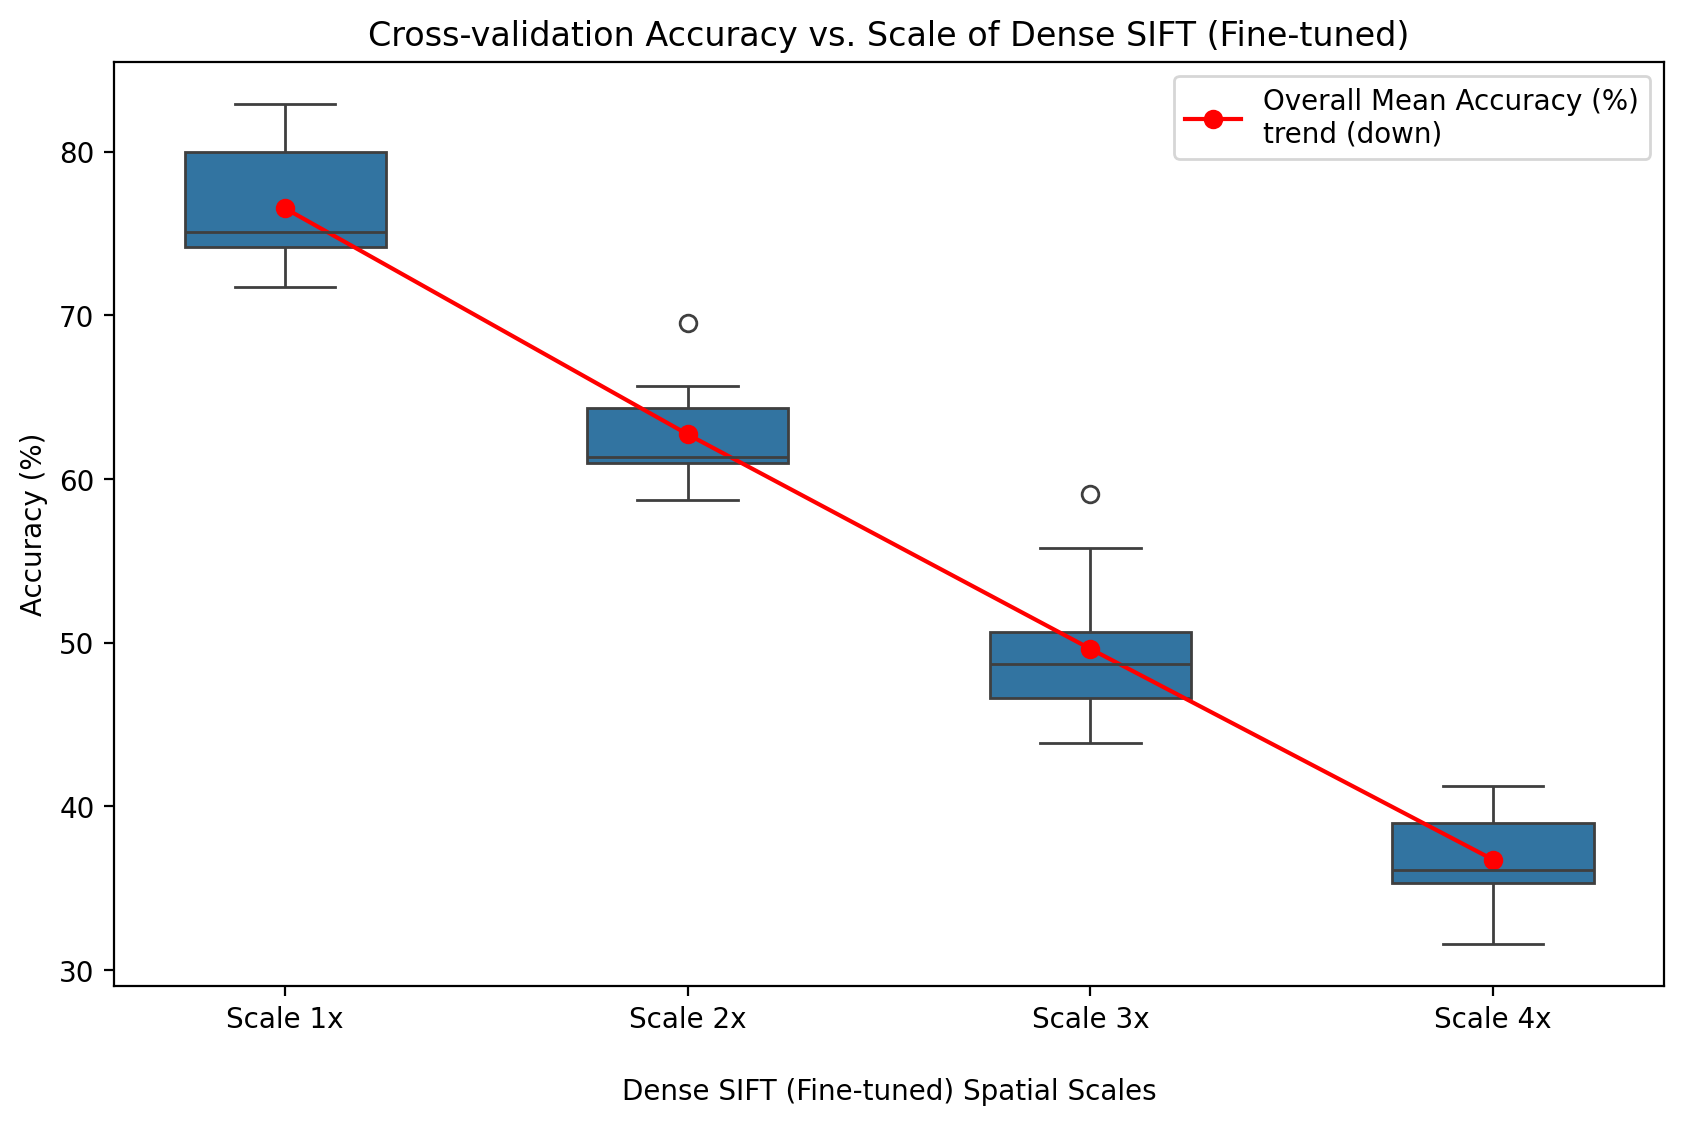

In [11]:
accuracy_df = pd.DataFrame({
    'Scale 1x\n': crossval_acc_DENSE_SIFT_fine_1x,
    'Scale 2x': crossval_acc_DENSE_SIFT_fine_2x,
    'Scale 3x': crossval_acc_DENSE_SIFT_fine_3x,
    'Scale 4x': crossval_acc_DENSE_SIFT_fine_4x
})

df = accuracy_df.melt(var_name='Scale', value_name='Accuracy')
plt.figure(figsize=(10, 6))
seaborn.boxplot(data=df, x='Scale', y='Accuracy', width=0.5)
mean_values = accuracy_df.mean()
plt.plot(mean_values.index, mean_values.values, marker='o', color='r', label='Overall Mean Accuracy (%)\ntrend (down)')
plt.title('Cross-validation Accuracy vs. Scale of Dense SIFT (Fine-tuned)')
plt.xlabel('Dense SIFT (Fine-tuned) Spatial Scales')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

###  Feature normalization

We try different scaling methods to know if the results improve with a normalization of the visual words histograms. The methods used are:

- `StandardScaler()`
- `MinMaxScaler()`
- `Normalizer()`

In [18]:
def pipeline_dense_sift_norm(step_size, norm_method = scaler, nfeatures=185, nOctaveLayers=2, cross_val=False, pca=False, lda=False):
    # Compute descriptors train & test
    Detector_DENSE_SIFT_NORM = cv2.SIFT_create(nfeatures=nfeatures,nOctaveLayers=nOctaveLayers)
    Train_descriptors_DENSE_SIFT_NORM, Train_label_per_descriptor_DENSE_SIFT_NORM = compute_dense_descriptors(Detector_DENSE_SIFT_NORM, step_size)
    Test_descriptors_DENSE_SIFT_NORM, Test_label_per_descriptor_DENSE_SIFT_NORM = compute_dense_descriptors(Detector_DENSE_SIFT_NORM, step_size, test_images_filenames, test_labels)
        
    # Clustering (n_clusters = k) of the feature space
    k = 128
    codebook_DENSE_SIFT_NORM = MiniBatchKMeans(n_init=3, n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook_DENSE_SIFT_NORM.fit(np.vstack(Train_descriptors_DENSE_SIFT_NORM))
    
    # BoVW train & test
    Train_visual_words_DENSE_SIFT_NORM = predict_BoVW(codebook_DENSE_SIFT_NORM, Train_descriptors_DENSE_SIFT_NORM, k_=k)
    Test_visual_words_DENSE_SIFT_NORM = predict_BoVW(codebook_DENSE_SIFT_NORM, Test_descriptors_DENSE_SIFT_NORM, k_=k)
    
    if pca:
        pca_ = PCA(n_components=64)
        Train_visual_words_DENSE_SIFT_NORM = pca_.fit_transform(Train_visual_words_DENSE_SIFT_NORM)
    if lda:
        lda_ = LinearDiscriminantAnalysis(n_components=7)
        Train_visual_words_DENSE_SIFT_NORM = lda_.fit_transform(Train_visual_words_DENSE_SIFT_NORM, train_labels)
        
    # Classifier (kNN)
    Train_visual_words_DENSE_SIFT_NORM = norm_method.fit_transform(Train_visual_words_DENSE_SIFT_NORM) 
    knn_DENSE_SIFT_NORM = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knn_DENSE_SIFT_NORM.fit(Train_visual_words_DENSE_SIFT_NORM, train_labels) 
    
    if pca:
        Test_visual_words_DENSE_SIFT_NORM = pca_.transform(Test_visual_words_DENSE_SIFT_NORM)
    if lda:
        Test_visual_words_DENSE_SIFT_NORM = lda_.transform(Test_visual_words_DENSE_SIFT_NORM)

    # Test score
    Test_visual_words_DENSE_SIFT_NORM = norm_method.fit_transform(Test_visual_words_DENSE_SIFT_NORM)
    test_acc_DENSE_SIFT_NORM = knn_DENSE_SIFT_NORM.score(Test_visual_words_DENSE_SIFT_NORM, test_labels)

    # Cross-validation score (conditional for performance purposes)
    if cross_val:
        X_DENSE_SIFT_NORM = Train_descriptors_DENSE_SIFT_NORM + Test_descriptors_DENSE_SIFT_NORM
        VW_DENSE_SIFT_NORM = np.concatenate([Train_visual_words_DENSE_SIFT_NORM, Test_visual_words_DENSE_SIFT_NORM], axis=0)
        Y_labels = train_labels + test_labels
    
        crossval_acc_DENSE_SIFT_NORM = cross_val_score(knn_DENSE_SIFT_NORM, np.vstack(VW_DENSE_SIFT_NORM), Y_labels, cv=n_folds)
            
        return 100*test_acc_DENSE_SIFT_NORM, 100*crossval_acc_DENSE_SIFT_NORM
    
    return 100*test_acc_DENSE_SIFT_NORM


In [23]:

print("Dense SIFT (Default norm w/ LDA)\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_fine_lda,2), round(np.mean(crossval_acc_DENSE_SIFT_fine_lda) , 2))) 

scaler = StandardScaler()
test_acc_DENSE_SIFT_STD, crossval_acc_DENSE_SIFT_STD = pipeline_dense_sift_norm(step_size,scaler, cross_val=True)
print("Dense SIFT (Norm Method = {})\t Test Accuracy: {}\t Cross-val: {}".format('StandardScaler()', round(test_acc_DENSE_SIFT_STD, 2), round(np.mean(crossval_acc_DENSE_SIFT_STD), 2)))

scaler = MinMaxScaler()
test_acc_DENSE_SIFT_MINMAX, crossval_acc_DENSE_SIFT_MINMAX = pipeline_dense_sift_norm(step_size,scaler, cross_val=True)
print("Dense SIFT (Norm Method = {})\t Test Accuracy: {}\t Cross-val: {}".format('MinMAxScaler()', round(test_acc_DENSE_SIFT_MINMAX, 2), round(np.mean(crossval_acc_DENSE_SIFT_MINMAX), 2)))

transformer = Normalizer()
test_acc_DENSE_SIFT_NORMAL, crossval_acc_DENSE_SIFT_NORMAL = pipeline_dense_sift_norm(step_size,transformer, cross_val=True)
print("Dense SIFT (Norm Method = {})\t Test Accuracy: {}\t Cross-val: {}".format('Normalizer()', round(test_acc_DENSE_SIFT_NORMAL, 2), round(np.mean(crossval_acc_DENSE_SIFT_NORMAL), 2)))


Dense SIFT (Default norm w/ LDA)	 Test Accuracy: 78.56	 Cross-val: 81.69
Dense SIFT (Norm Method = StandardScaler())	 Test Accuracy: 74.72	 Cross-val: 75.3
Dense SIFT (Norm Method = MinMAxScaler())	 Test Accuracy: 74.72	 Cross-val: 75.56
Dense SIFT (Norm Method = Normalizer())	 Test Accuracy: 76.58	 Cross-val: 76.15


#### Reducing dimensionality

In [24]:
#PCA
scaler = StandardScaler()
test_acc_DENSE_SIFT_STD_pca, crossval_acc_DENSE_SIFT_STD_pca = pipeline_dense_sift_norm(step_size,scaler, cross_val=True, pca=True)
print("Dense SIFT (Norm Method = {}w/ PCA)\t Test Accuracy: {}\t Cross-val: {}".format('StandardScaler()', round(test_acc_DENSE_SIFT_STD_pca, 2), round(np.mean(crossval_acc_DENSE_SIFT_STD_pca), 2)))

scaler = MinMaxScaler()
test_acc_DENSE_SIFT_MINMAX_pca, crossval_acc_DENSE_SIFT_MINMAX_pca = pipeline_dense_sift_norm(step_size,scaler, cross_val=True,pca=True)
print("Dense SIFT (Norm Method = {}w/ PCA)\t Test Accuracy: {}\t Cross-val: {}".format('MinMAxScaler()', round(test_acc_DENSE_SIFT_MINMAX_pca, 2), round(np.mean(crossval_acc_DENSE_SIFT_MINMAX_pca), 2)))

transformer = Normalizer()
test_acc_DENSE_SIFT_NORMAL_pca, crossval_acc_DENSE_SIFT_NORMAL_pca = pipeline_dense_sift_norm(step_size,transformer, cross_val=True,pca=True)
print("Dense SIFT (Norm Method = {}w/ PCA)\t Test Accuracy: {}\t Cross-val: {}".format('Normalizer()', round(test_acc_DENSE_SIFT_NORMAL_pca, 2), round(np.mean(crossval_acc_DENSE_SIFT_NORMAL_pca), 2)))

#LDA
scaler = StandardScaler()
test_acc_DENSE_SIFT_STD_lda, crossval_acc_DENSE_SIFT_STD_lda = pipeline_dense_sift_norm(step_size,scaler, cross_val=True, lda=True)
print("Dense SIFT (Norm Method = {}w/ LDA)\t Test Accuracy: {}\t Cross-val: {}".format('StandardScaler()', round(test_acc_DENSE_SIFT_STD_lda, 2), round(np.mean(crossval_acc_DENSE_SIFT_STD_lda), 2)))

scaler = MinMaxScaler()
test_acc_DENSE_SIFT_MINMAX_lda, crossval_acc_DENSE_SIFT_MINMAX_lda = pipeline_dense_sift_norm(step_size,scaler, cross_val=True,lda=True)
print("Dense SIFT (Norm Method = {}w/ LDA)\t Test Accuracy: {}\t Cross-val: {}".format('MinMAxScaler()', round(test_acc_DENSE_SIFT_MINMAX_lda, 2), round(np.mean(crossval_acc_DENSE_SIFT_MINMAX_lda), 2)))

transformer = Normalizer()
test_acc_DENSE_SIFT_NORMAL_lda, crossval_acc_DENSE_SIFT_NORMAL_lda = pipeline_dense_sift_norm(step_size,transformer, cross_val=True,lda=True)
print("Dense SIFT (Norm Method = {}w/ LDA)\t Test Accuracy: {}\t Cross-val: {}".format('Normalizer()', round(test_acc_DENSE_SIFT_NORMAL_lda, 2), round(np.mean(crossval_acc_DENSE_SIFT_NORMAL_lda), 2)))


Dense SIFT (Norm Method = StandardScaler() w/ PCA)	 Test Accuracy: 73.48	 Cross-val: 71.17
Dense SIFT (Norm Method = MinMAxScaler()w/ PCA)	 Test Accuracy: 72.12	 Cross-val: 71.76
Dense SIFT (Norm Method = Normalizer() w/ PCA)	 Test Accuracy: 76.83	 Cross-val: 75.56
Dense SIFT (Norm Method = StandardScaler() w/ LDA)	 Test Accuracy: 78.07	 Cross-val: 81.03
Dense SIFT (Norm Method = MinMAxScaler()w/ LDA)	 Test Accuracy: 78.93	 Cross-val: 82.14
Dense SIFT (Norm Method = Normalizer() w/ LDA)	 Test Accuracy: 79.43	 Cross-val: 81.58


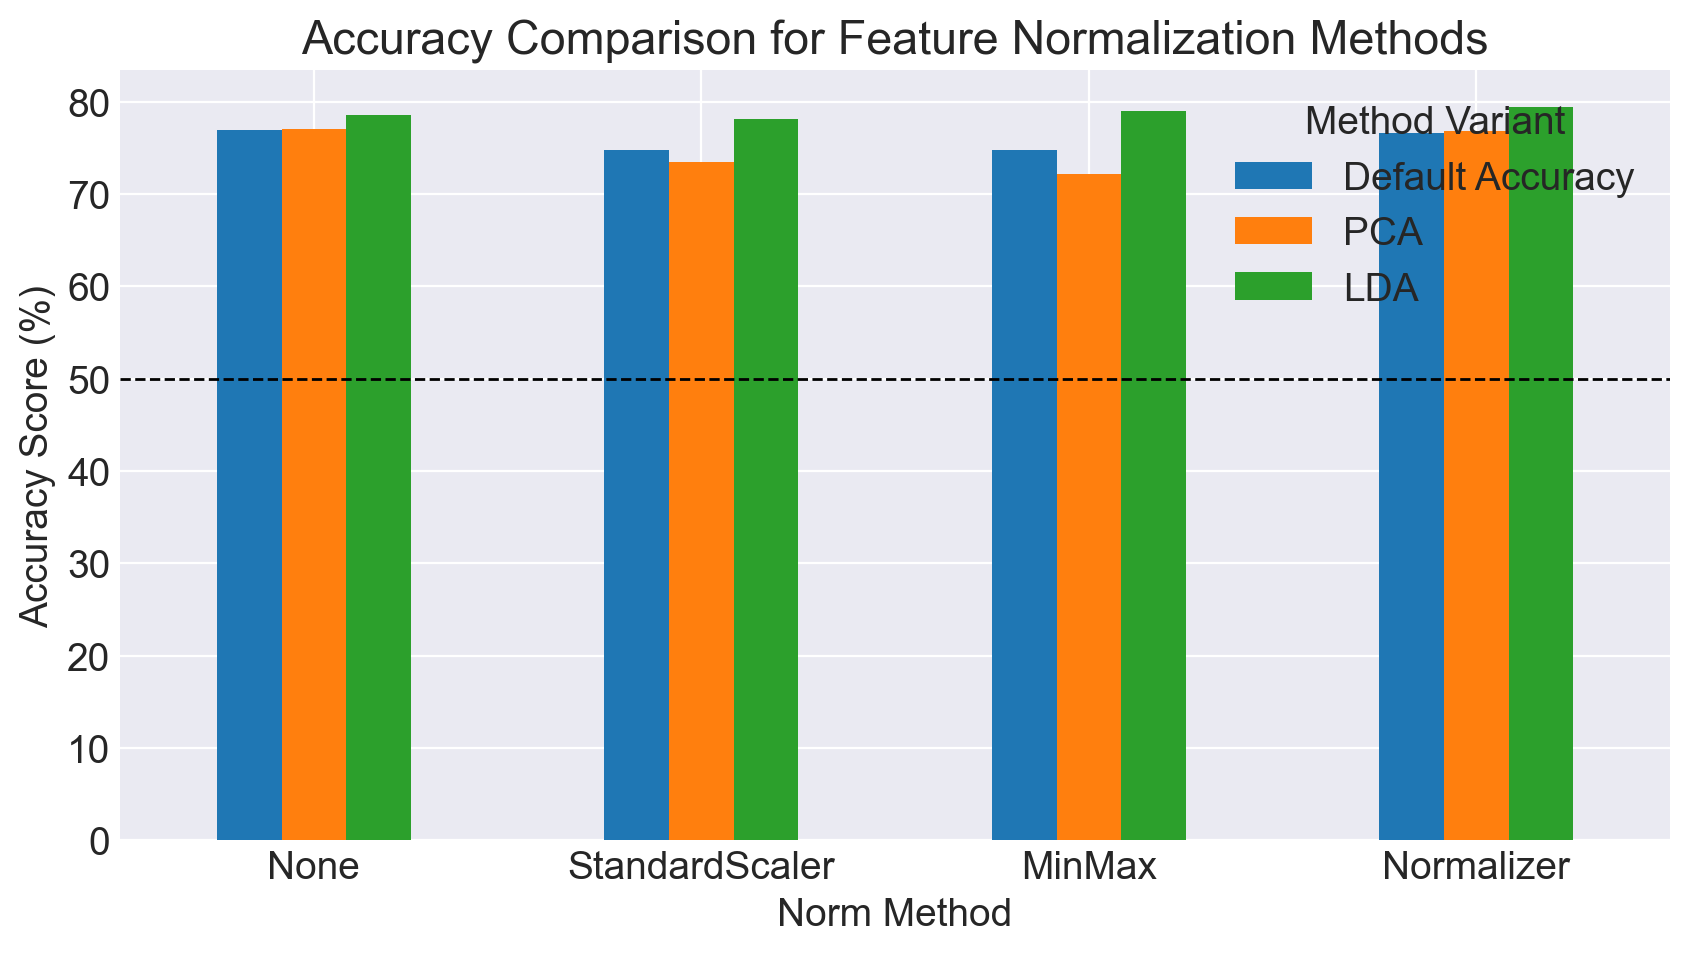

In [29]:
data = {
    'Method': ['None', 'StandardScaler', 'MinMax', 'Normalizer'],
    'Default Accuracy': [test_acc_DENSE_SIFT_fine ,test_acc_DENSE_SIFT_STD, test_acc_DENSE_SIFT_MINMAX, test_acc_DENSE_SIFT_NORMAL],
    'PCA': [test_acc_DENSE_SIFT_fine_pca, test_acc_DENSE_SIFT_STD_pca, test_acc_DENSE_SIFT_MINMAX_pca, test_acc_DENSE_SIFT_NORMAL_pca],
    'LDA': [test_acc_DENSE_SIFT_fine_lda, test_acc_DENSE_SIFT_STD_lda, test_acc_DENSE_SIFT_MINMAX_lda, test_acc_DENSE_SIFT_NORMAL_lda]
}

accuracy_df = pd.DataFrame(data)
plt.style.use('seaborn-v0_8-darkgrid')
accuracy_df.set_index('Method').plot(kind='bar', figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)
plt.title('Accuracy Comparison for Feature Normalization Methods')
plt.ylabel('Accuracy Score (%)')
plt.xlabel('Norm Method')
plt.xticks(rotation=0)
plt.ylim(57, 84)
plt.legend(title='Method Variant', loc='lower left', bbox_to_anchor=(-0.4, 0.7))
plt.show()

#### Cross-val

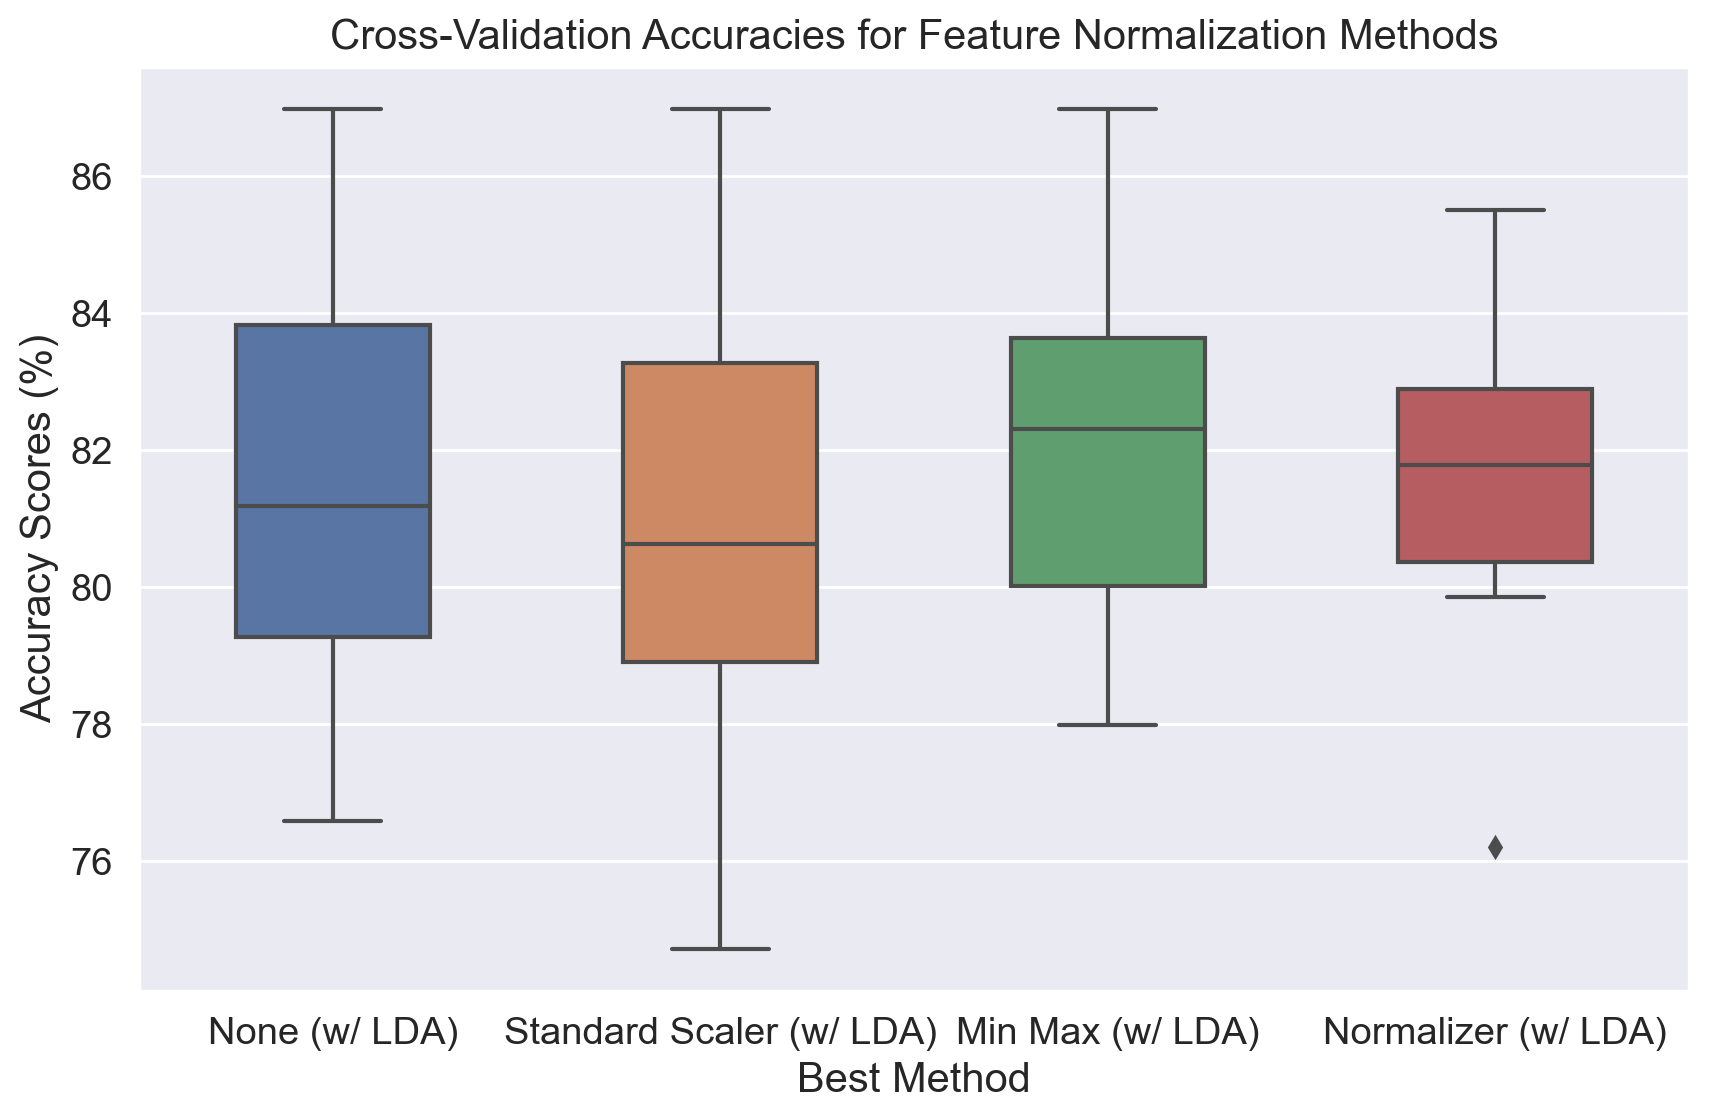

In [35]:
data = {
    'None (w/ LDA)': crossval_acc_DENSE_SIFT_fine_lda,
    'Standard Scaler (w/ LDA)': crossval_acc_DENSE_SIFT_STD_lda,
    'Min Max (w/ LDA)': crossval_acc_DENSE_SIFT_MINMAX_lda,
    'Normalizer (w/ LDA)': crossval_acc_DENSE_SIFT_NORMAL_lda
}

accuracy_df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
seaborn.set(font_scale=1.25)
seaborn.boxplot(data=accuracy_df, width=0.5)

plt.title('Cross-Validation Accuracies for Feature Normalization Methods')
plt.ylabel('Accuracy Scores (%)')
plt.xlabel('Best Method')

plt.show()

### Codebook size

Now we are going to try different sizes for the visual word dictionary in order to know which is the best number of visual words. Again we are going to use Optuna.

In [40]:
def obj_k_codebook(trial):
    k = trial.suggest_int("k_codebook", 100, 1000, log=True)
    test_acc_DENSE_SIFT = pipeline_dense_sift(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=False,k_codebook=k )
    return test_acc_DENSE_SIFT
    
study = optuna.create_study(direction = "maximize")
study.optimize(obj_k_codebook, n_trials = 20)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-12-26 10:46:49,851] A new study created in memory with name: no-name-fc9ab372-ce0a-4dd5-8da9-374e055e64bd
[I 2023-12-26 10:47:22,038] Trial 0 finished with value: 77.44733581164807 and parameters: {'k_codebook': 299}. Best is trial 0 with value: 77.44733581164807.
[I 2023-12-26 10:48:12,599] Trial 1 finished with value: 76.82775712515489 and parameters: {'k_codebook': 602}. Best is trial 0 with value: 77.44733581164807.
[I 2023-12-26 10:48:43,348] Trial 2 finished with value: 77.07558859975217 and parameters: {'k_codebook': 166}. Best is trial 0 with value: 77.44733581164807.
[I 2023-12-26 10:49:17,575] Trial 3 finished with value: 77.07558859975217 and parameters: {'k_codebook': 262}. Best is trial 0 with value: 77.44733581164807.
[I 2023-12-26 10:50:01,230] Trial 4 finished with value: 76.82775712515489 and parameters: {'k_codebook': 417}. Best is trial 0 with value: 77.44733581164807.
[I 2023-12-26 10:50:33,833] Trial 5 finished with value: 77.94299876084263 and parameters: 

Best Score:  78.81040892193309
Best Params: 
  k_codebook: 198


The best **k_codebook** size is: **198**

Now we are going to reduce dimensionality:

In [43]:
print("Dense SIFT (K = 128)\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_fine,2), round(np.mean(crossval_acc_DENSE_SIFT_fine), 2))) 

# K= Dense SIFT
K=198
test_acc_DENSE_SIFT_codebook, crossval_acc_DENSE_SIFT_codebook = pipeline_dense_sift(step_size=18, nfeatures=185, nOctaveLayers=2, cross_val=True, k_codebook=K)
print("Dense SIFT (K = 198)\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_codebook, 2), round(np.mean(crossval_acc_DENSE_SIFT_codebook), 2)))

# K=  Dense SIFT + PCA
K=198
test_acc_DENSE_SIFT_codebook_pca, crossval_acc_DENSE_SIFT_codebook_pca = pipeline_dense_sift(step_size=18, nfeatures=185, nOctaveLayers=2, cross_val=True, pca=True, k_codebook=K)
print("Dense SIFT (K = 198) PCA \t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_codebook_pca, 2), round(np.mean(crossval_acc_DENSE_SIFT_codebook_pca), 2)))

# K= Dense SIFT + LDA
K=198
test_acc_DENSE_SIFT_codebook_lda, crossval_acc_DENSE_SIFT_codebook_lda = pipeline_dense_sift(step_size=18, nfeatures=185, nOctaveLayers=2, cross_val=True, lda=True, k_codebook=K)
print("Dense SIFT (K = 198) LDA \t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_codebook_lda, 2), round(np.mean(crossval_acc_DENSE_SIFT_codebook_lda), 2)))


Dense SIFT (K = 128)	 Test Accuracy: 76.95	 Cross-val: 76.6
Dense SIFT (K = 198)	 Test Accuracy: 78.81	 Cross-val: 77.2
Dense SIFT (K = 198) PCA 	 Test Accuracy: 76.33	 Cross-val: 76.56
Dense SIFT (K = 198) LDA 	 Test Accuracy: 80.17	 Cross-val: 84.71


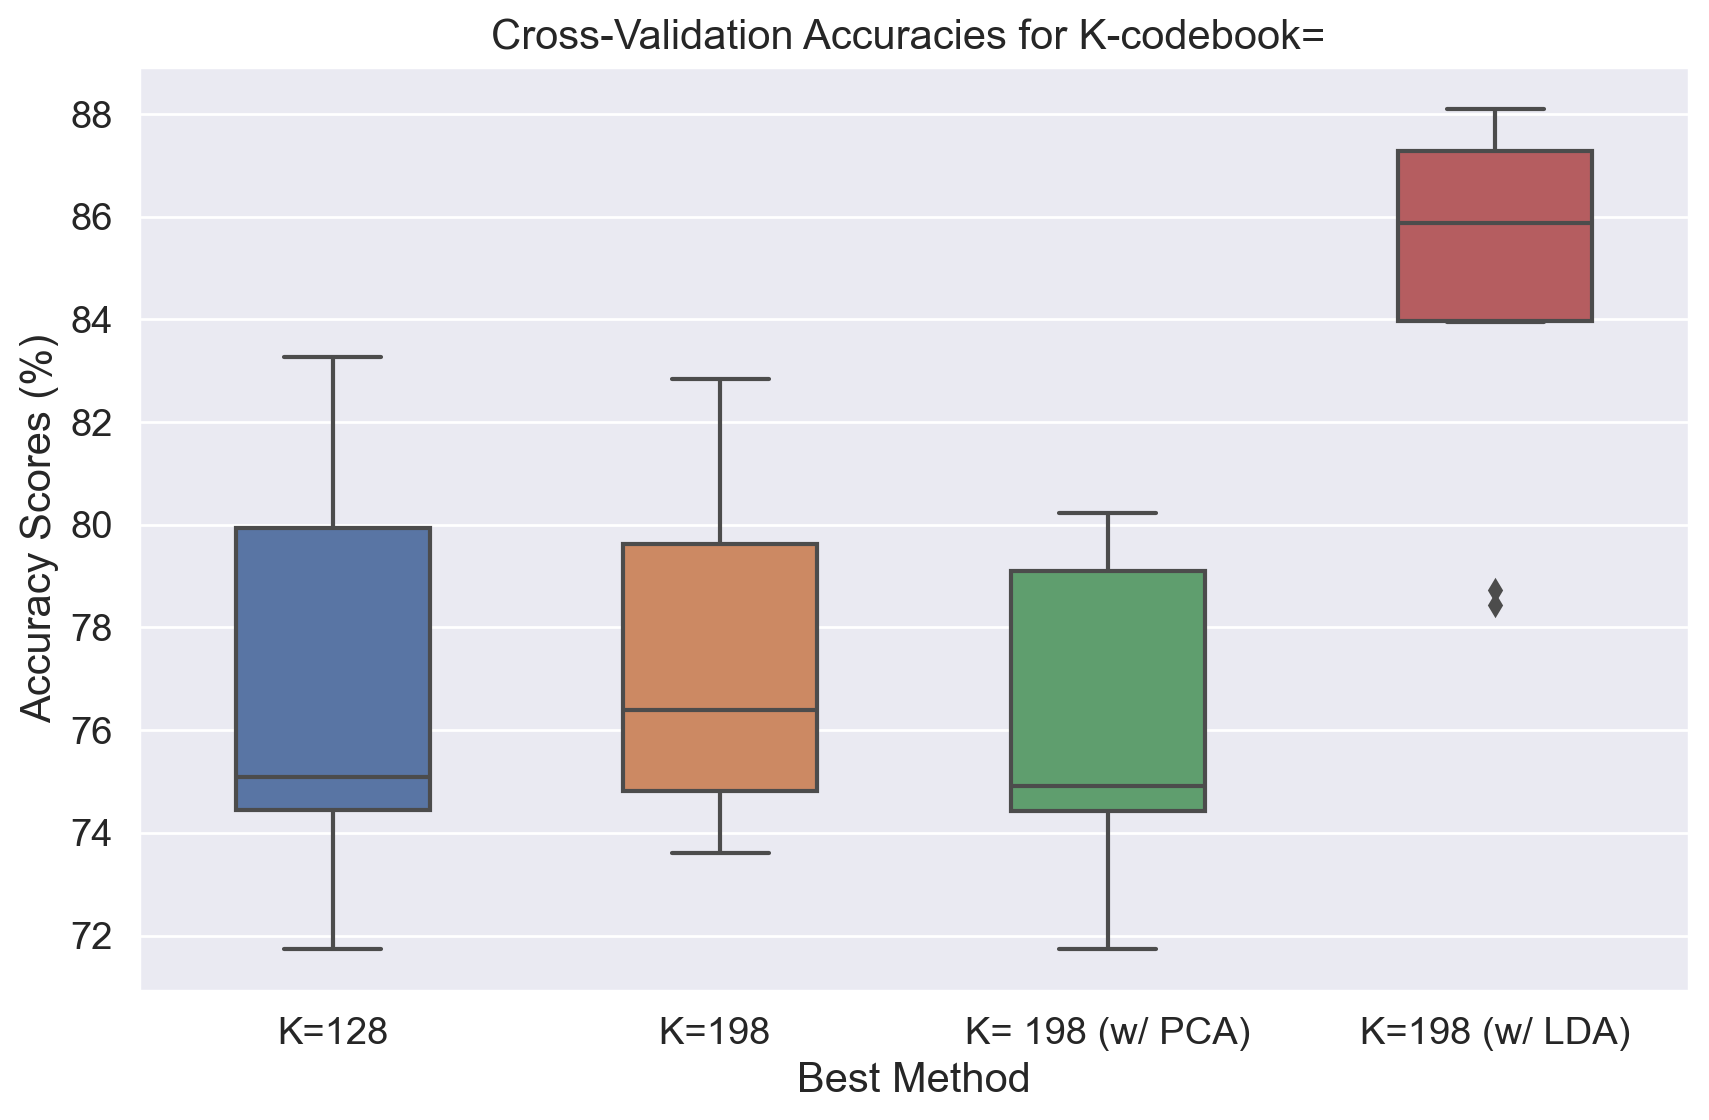

In [42]:
data = {
    'K = 128': crossval_acc_DENSE_SIFT_fine,
    'K = 198 ': crossval_acc_DENSE_SIFT_codebook,
    'K = 198 (w/ PCA)': crossval_acc_DENSE_SIFT_codebook_pca,
    'K = 198 (w/ LDA)': crossval_acc_DENSE_SIFT_codebook_lda
}

accuracy_df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
seaborn.set(font_scale=1.25)
seaborn.boxplot(data=accuracy_df, width=0.5)

plt.title('Cross-Validation Accuracies for K-codebook= 198')
plt.ylabel('Accuracy Scores (%)')
plt.xlabel('Best Method')

plt.show()

### N neighbors of KNN classifier

Now we are going to improve our results by modifying the neighbors number of the KNN classifier. Again we are going to use Optuna: 

In [47]:
def obj_k_KNN(trial):
    n_neighbors= trial.suggest_int("n_neighbors", 3, 20, log=True)
    test_acc_DENSE_SIFT = pipeline_dense_sift(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=False,k_codebook=198,k_neighbors=n_neighbors )
    return test_acc_DENSE_SIFT
    
study = optuna.create_study(direction = "maximize")
study.optimize(obj_k_KNN, n_trials = 20)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-12-26 11:15:17,743] A new study created in memory with name: no-name-b972c6d7-3325-4127-9912-ff5a268b6ea0
[I 2023-12-26 11:15:47,951] Trial 0 finished with value: 75.96034696406444 and parameters: {'n_neighbors': 3}. Best is trial 0 with value: 75.96034696406444.
[I 2023-12-26 11:16:19,591] Trial 1 finished with value: 75.96034696406444 and parameters: {'n_neighbors': 3}. Best is trial 0 with value: 75.96034696406444.
[I 2023-12-26 11:16:51,919] Trial 2 finished with value: 76.70384138785626 and parameters: {'n_neighbors': 8}. Best is trial 2 with value: 76.70384138785626.
[I 2023-12-26 11:17:25,198] Trial 3 finished with value: 75.96034696406444 and parameters: {'n_neighbors': 14}. Best is trial 2 with value: 76.70384138785626.
[I 2023-12-26 11:17:58,149] Trial 4 finished with value: 78.1908302354399 and parameters: {'n_neighbors': 7}. Best is trial 4 with value: 78.1908302354399.
[I 2023-12-26 11:18:31,341] Trial 5 finished with value: 75.96034696406444 and parameters: {'n_ne

Best Score:  78.81040892193309
Best Params: 
  n_neighbors: 5


Like the best vale for **n_neighbors** is: **5** and it is the value used in previous steps we are not going to recalculate the cross-val and the reduced dimensionality values.

### Different distances in Knn

In all the previous kernels we were using Euclidean distance in the KNN classifier method. There are other distances that we can use:

- Euclidean
- Cosine
- Jaccard


In [54]:
print("Dense SIFT (Distance = {})\t Test Accuracy: {}\t Cross-val: {}".format('Euclidean',round(test_acc_DENSE_SIFT_codebook,2), round(np.mean(crossval_acc_DENSE_SIFT_codebook), 2))) 

distance='cosine'
test_acc_DENSE_SIFT_cosine, crossval_acc_DENSE_SIFT_cosine = pipeline_dense_sift(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,k_codebook=198,k_neighbors=5,distance=distance)
print("Dense SIFT (Distance = {})\t Test Accuracy: {}\t Cross-val: {}".format('Cosine', round(test_acc_DENSE_SIFT_cosine, 2), round(np.mean(crossval_acc_DENSE_SIFT_cosine), 2)))

distance='jaccard'
test_acc_DENSE_SIFT_jaccard, crossval_acc_DENSE_SIFT_jaccard = pipeline_dense_sift(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,k_codebook=198,k_neighbors=5,distance=distance)
print("Dense SIFT (Distance = {})\t Test Accuracy: {}\t Cross-val: {}".format('Jaccard', round(test_acc_DENSE_SIFT_jaccard, 2), round(np.mean(crossval_acc_DENSE_SIFT_jaccard), 2)))


Dense SIFT (Distance = Euclidean)	 Test Accuracy: 78.81	 Cross-val: 77.2
Dense SIFT (Distance = Cosine)	 Test Accuracy: 75.96	 Cross-val: 75.74


/Users/marcocordonvaquero/anaconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/marcocordonvaquero/anaconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/marcocordonvaquero/anaconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/marcocordonvaquero/anaconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/marcocordonvaquero/anaconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted

Dense SIFT (Distance = Jaccard)	 Test Accuracy: 73.98	 Cross-val: 73.4


/Users/marcocordonvaquero/anaconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Again the best value is the same that was used in all the previous steps so does not have sense to recalculate all again.

### SVM classifier

Now we are going to try other classifier like SVM. This classifier has different kernels that we can select:

- Linear
- RBF
- Histogram Intersection

We are going to try the 3 types and select the best.

In [135]:
def pipeline_dense_sift_SVM(step_size, nfeatures=0, nOctaveLayers=3, cross_val=False, pca=False, lda=False, k_codebook=128, k_neighbors=5, ker='linear', scaler=False):
    # Compute descriptors train & test
    Detector_DENSE_SIFT = cv2.SIFT_create(nfeatures=nfeatures,nOctaveLayers=nOctaveLayers)
    Train_descriptors_DENSE_SIFT, Train_label_per_descriptor_DENSE_SIFT = compute_dense_descriptors(Detector_DENSE_SIFT, step_size)
    Test_descriptors_DENSE_SIFT, Test_label_per_descriptor_DENSE_SIFT = compute_dense_descriptors(Detector_DENSE_SIFT, step_size, test_images_filenames, test_labels)
        
    # Clustering (n_clusters = k) of the feature space
    k = k_codebook
    codebook_DENSE_SIFT = MiniBatchKMeans(n_init=3, n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook_DENSE_SIFT.fit(np.vstack(Train_descriptors_DENSE_SIFT))
    
    # BoVW train & test
    Train_visual_words_DENSE_SIFT = predict_BoVW(codebook_DENSE_SIFT, Train_descriptors_DENSE_SIFT, k_=k)
    Test_visual_words_DENSE_SIFT = predict_BoVW(codebook_DENSE_SIFT, Test_descriptors_DENSE_SIFT, k_=k)
    
    if pca:
        pca_ = PCA(n_components=109)
        Train_visual_words_DENSE_SIFT = pca_.fit_transform(Train_visual_words_DENSE_SIFT)
    if lda:
        lda_ = LinearDiscriminantAnalysis(n_components=7)
        Train_visual_words_DENSE_SIFT = lda_.fit_transform(Train_visual_words_DENSE_SIFT, train_labels)
    if scaler:
        Train_visual_words_DENSE_SIFT = scaler.fit_transform(Train_visual_words_DENSE_SIFT) 
        
    # Classifier (SVM)
    model=svm.SVC(kernel=ker)
    model.fit(Train_visual_words_DENSE_SIFT, train_labels) 
    
    if pca:
        Test_visual_words_DENSE_SIFT = pca_.transform(Test_visual_words_DENSE_SIFT)
    if lda:
        Test_visual_words_DENSE_SIFT = lda_.transform(Test_visual_words_DENSE_SIFT)
    if scaler:
        Test_visual_words_DENSE_SIFT = scaler.transform(Test_visual_words_DENSE_SIFT) 

    # Test score
    test_acc_DENSE_SIFT = model.score(Test_visual_words_DENSE_SIFT, test_labels)

    # Cross-validation score (conditional for performance purposes)
    if cross_val:
        X_DENSE_SIFT = Train_descriptors_DENSE_SIFT + Test_descriptors_DENSE_SIFT
        VW_DENSE_SIFT = np.concatenate([Train_visual_words_DENSE_SIFT, Test_visual_words_DENSE_SIFT], axis=0)
        Y_labels = train_labels + test_labels
    
        crossval_acc_DENSE_SIFT = cross_val_score(model, np.vstack(VW_DENSE_SIFT), Y_labels, cv=n_folds)
            
        return 100*test_acc_DENSE_SIFT, 100*crossval_acc_DENSE_SIFT
    
    return 100*test_acc_DENSE_SIFT


In [56]:
def histogram_intersection_kernel(x,u):
    K = np.zeros((x.shape[0],u.shape[0]))
    for i in range(x.shape[1]):
        col_1 = x[:, i].reshape(-1, 1)
        col_2 = u[:, i].reshape(-1, 1)
        K += np.minimum(col_1, col_2.T)
    return K

In [59]:
print("KNN\t Test Accuracy: {}\t Cross-val: {}".format(round(test_acc_DENSE_SIFT_codebook,2), round(np.mean(crossval_acc_DENSE_SIFT_codebook), 2))) 

ker= 'linear'
test_acc_DENSE_SIFT_SVM_linear, crossval_acc_DENSE_SIFT_SVM_linear = pipeline_dense_sift_SVM(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,k_codebook=198,k_neighbors=5,ker=ker )
print("SVM (Kernel = {})\t Test Accuracy: {}\t Cross-val: {}".format('Linear', round(test_acc_DENSE_SIFT_SVM_linear, 2), round(np.mean(crossval_acc_DENSE_SIFT_SVM_linear), 2)))

ker='rbf'
test_acc_DENSE_SIFT_SVM_rbf, crossval_acc_DENSE_SIFT_SVM_rbf = pipeline_dense_sift_SVM(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,k_codebook=198,k_neighbors=5,ker=ker )
print("SVM (Kernel = {})\t Test Accuracy: {}\t Cross-val: {}".format('RBF', round(test_acc_DENSE_SIFT_SVM_rbf, 2), round(np.mean(crossval_acc_DENSE_SIFT_SVM_rbf), 2)))

ker= histogram_intersection_kernel
test_acc_DENSE_SIFT_SVM_hist_intersec, crossval_acc_DENSE_SIFT_SVM_hist_intersec = pipeline_dense_sift_SVM(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,k_codebook=198,k_neighbors=5,ker=ker )
print("SVM (Kernel = {})\t Test Accuracy: {}\t Cross-val: {}".format('Histogram Intersec', round(test_acc_DENSE_SIFT_SVM_hist_intersec, 2), round(np.mean(crossval_acc_DENSE_SIFT_SVM_hist_intersec), 2)))


KNN	 Test Accuracy: 78.81	 Cross-val: 77.2
SVM (Kernel = Linear)	 Test Accuracy: 78.56	 Cross-val: 77.53
SVM (Kernel = RBF)	 Test Accuracy: 82.9	 Cross-val: 82.78
SVM (Kernel = Histogram Intersec)	 Test Accuracy: 81.41	 Cross-val: 80.06


As we can se the best **kernel** is: **RBF** and its value its better than using KNN.

Now we are going to reduce dimensionality:

In [60]:
#PCA
ker= 'linear'
test_acc_DENSE_SIFT_SVM_linear_pca, crossval_acc_DENSE_SIFT_SVM_linear_pca = pipeline_dense_sift_SVM(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,pca=True,k_codebook=198,k_neighbors=5,ker=ker )
print("SVM PCA (Kernel = {})\t Test Accuracy: {}\t Cross-val: {}".format('Linear', round(test_acc_DENSE_SIFT_SVM_linear_pca, 2), round(np.mean(crossval_acc_DENSE_SIFT_SVM_linear_pca), 2)))

ker='rbf'
test_acc_DENSE_SIFT_SVM_rbf_pca, crossval_acc_DENSE_SIFT_SVM_rbf_pca = pipeline_dense_sift_SVM(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,pca=True,k_codebook=198,k_neighbors=5,ker=ker )
print("SVM PCA (Kernel = {})\t Test Accuracy: {}\t Cross-val: {}".format('RBF', round(test_acc_DENSE_SIFT_SVM_rbf_pca, 2), round(np.mean(crossval_acc_DENSE_SIFT_SVM_rbf_pca), 2)))

ker= histogram_intersection_kernel
test_acc_DENSE_SIFT_SVM_hist_intersec_pca, crossval_acc_DENSE_SIFT_SVM_hist_intersec_pca = pipeline_dense_sift_SVM(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,pca=True,k_codebook=198,k_neighbors=5,ker=ker )
print("SVM PCA (Kernel = {})\t Test Accuracy: {}\t Cross-val: {}".format('Histogram Intersec', round(test_acc_DENSE_SIFT_SVM_hist_intersec_pca, 2), round(np.mean(crossval_acc_DENSE_SIFT_SVM_hist_intersec_pca), 2)))

#LDA
ker= 'linear'
test_acc_DENSE_SIFT_SVM_linear_lda, crossval_acc_DENSE_SIFT_SVM_linear_lda = pipeline_dense_sift_SVM(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,lda=True,k_codebook=198,k_neighbors=5,ker=ker )
print("SVM LDA (Kernel = {})\t Test Accuracy: {}\t Cross-val: {}".format('Linear', round(test_acc_DENSE_SIFT_SVM_linear_lda, 2), round(np.mean(crossval_acc_DENSE_SIFT_SVM_linear_lda), 2)))

ker='rbf'
test_acc_DENSE_SIFT_SVM_rbf_lda, crossval_acc_DENSE_SIFT_SVM_rbf_lda = pipeline_dense_sift_SVM(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,lda=True,k_codebook=198,k_neighbors=5,ker=ker )
print("SVM LDA (Kernel = {})\t Test Accuracy: {}\t Cross-val: {}".format('RBF', round(test_acc_DENSE_SIFT_SVM_rbf_lda, 2), round(np.mean(crossval_acc_DENSE_SIFT_SVM_rbf_lda), 2)))

ker= histogram_intersection_kernel
test_acc_DENSE_SIFT_SVM_hist_intersec_lda, crossval_acc_DENSE_SIFT_SVM_hist_intersec_lda = pipeline_dense_sift_SVM(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,lda=True,k_codebook=198,k_neighbors=5,ker=ker )
print("SVM LDA (Kernel = {})\t Test Accuracy: {}\t Cross-val: {}".format('Histogram Intersec', round(test_acc_DENSE_SIFT_SVM_hist_intersec_lda, 2), round(np.mean(crossval_acc_DENSE_SIFT_SVM_hist_intersec_lda), 2)))


SVM PCA (Kernel = Linear)	 Test Accuracy: 78.93	 Cross-val: 77.42
SVM PCA (Kernel = RBF)	 Test Accuracy: 80.92	 Cross-val: 81.32
SVM PCA (Kernel = Histogram Intersec)	 Test Accuracy: 79.93	 Cross-val: 78.57
SVM LDA (Kernel = Linear)	 Test Accuracy: 81.66	 Cross-val: 86.27
SVM LDA (Kernel = RBF)	 Test Accuracy: 80.67	 Cross-val: 86.42
SVM LDA (Kernel = Histogram Intersec)	 Test Accuracy: 80.55	 Cross-val: 85.34


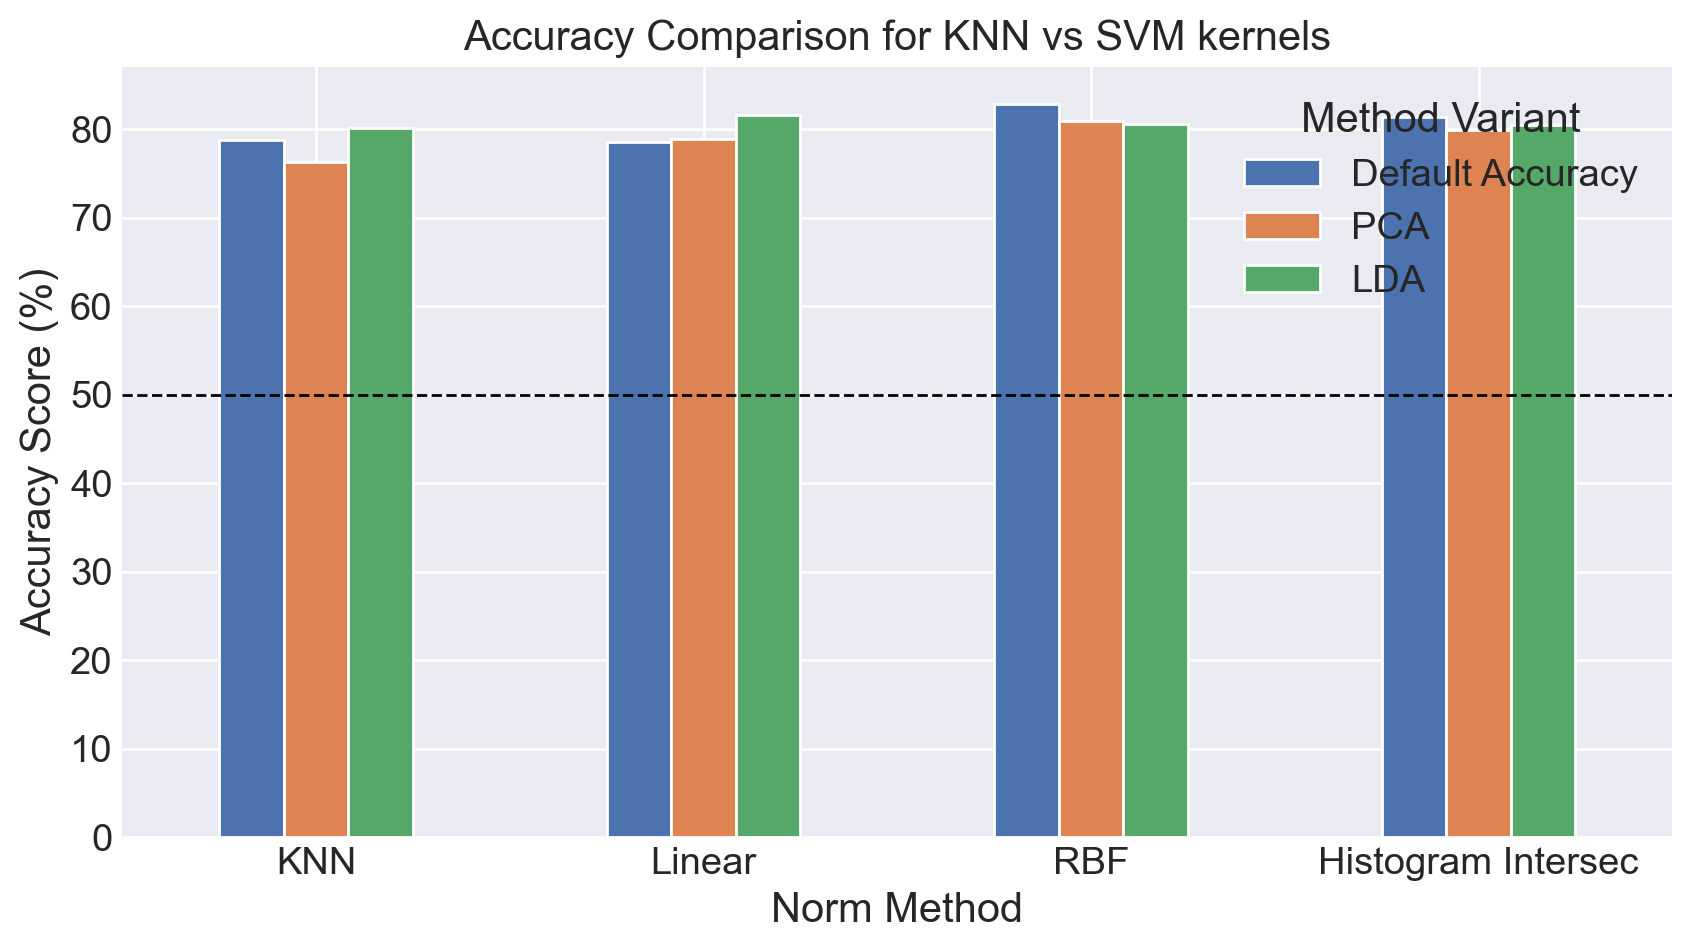

In [63]:
data = {
    'Kernel': ['KNN', 'SVM Linear Kernel', 'SVM RBF Kernel', 'SVM Hist. Inter. Kernel'],
    'Default Accuracy': [test_acc_DENSE_SIFT_codebook ,test_acc_DENSE_SIFT_SVM_linear, test_acc_DENSE_SIFT_SVM_rbf, test_acc_DENSE_SIFT_SVM_hist_intersec],
    'PCA': [test_acc_DENSE_SIFT_codebook_pca, test_acc_DENSE_SIFT_SVM_linear_pca, test_acc_DENSE_SIFT_SVM_rbf_pca, test_acc_DENSE_SIFT_SVM_hist_intersec_pca],
    'LDA': [test_acc_DENSE_SIFT_codebook_lda, test_acc_DENSE_SIFT_SVM_linear_lda, test_acc_DENSE_SIFT_SVM_rbf_lda,test_acc_DENSE_SIFT_SVM_hist_intersec_lda]
}

accuracy_df = pd.DataFrame(data)
plt.style.use('seaborn-v0_8-darkgrid')
accuracy_df.set_index('Kernel').plot(kind='bar', figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)
plt.title('Accuracy Comparison for KNN vs SVM kernels')
plt.ylabel('Accuracy Score (%)')
plt.xlabel('Different classification models')
plt.xticks(rotation=0)
plt.legend(title='Method Variant', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#### Cross Validation

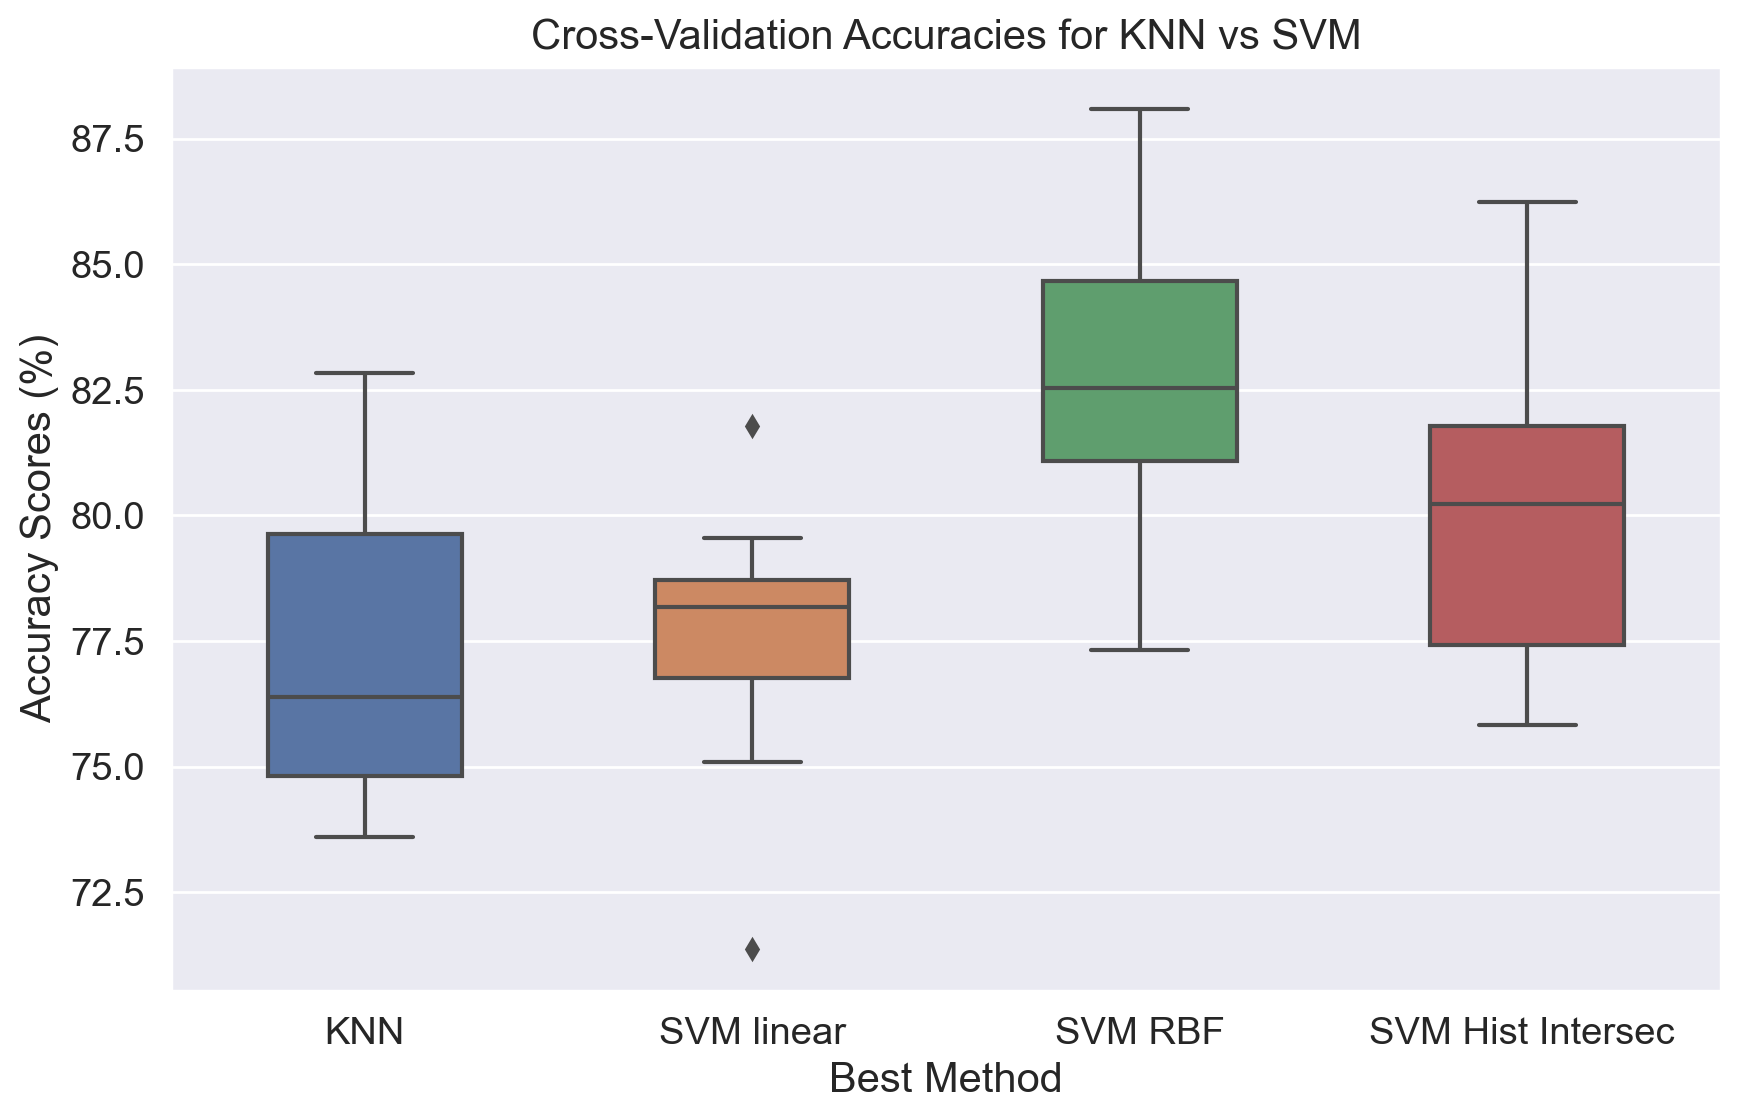

In [64]:
data = {
    'KNN': crossval_acc_DENSE_SIFT_codebook,
    'SVM linear': crossval_acc_DENSE_SIFT_SVM_linear,
    'SVM RBF': crossval_acc_DENSE_SIFT_SVM_rbf,
    'SVM Hist Intersec ': crossval_acc_DENSE_SIFT_SVM_hist_intersec
}

accuracy_df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
seaborn.set(font_scale=1.25)
seaborn.boxplot(data=accuracy_df, width=0.5)

plt.title('Cross-Validation Accuracies for KNN vs SVM')
plt.ylabel('Accuracy Scores (%)')
plt.xlabel('Best Method')

plt.show()

## Reducing dimensionality

In all the previous steps we always reduced the dimensionality using PCA and LDA. We can see that the most of the previous results are been improved reducing the dimensionality. 

Now using Optuna we are going to find the best params for PCA and LDA:

In [68]:
### Structure
step_size= 18
nfeatures = 185
nOctaveLayers = 2
k_codebook = 198
kernel='rbf'


Detector_DENSE_SIFT = cv2.SIFT_create(nfeatures=nfeatures,nOctaveLayers=nOctaveLayers)
Train_descriptors_DENSE_SIFT = []
Train_label_per_descriptor_DENSE_SIFT = []


for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]
    kpt,des=Detector_DENSE_SIFT.compute(gray,kp)
    Train_descriptors_DENSE_SIFT.append(des)
    Train_label_per_descriptor_DENSE_SIFT.append(labels)

D_DENSE_SIFT=np.vstack(Train_descriptors_DENSE_SIFT)

k = k_codebook
codebook_DENSE_SIFT = MiniBatchKMeans(n_init=3,n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook_DENSE_SIFT.fit(D_DENSE_SIFT)
visual_words_DENSE_SIFT=np.zeros((len(Train_descriptors_DENSE_SIFT),k),dtype=np.float32)
for i in range(len(Train_descriptors_DENSE_SIFT)):
    words_DENSE_SIFT=codebook_DENSE_SIFT.predict(Train_descriptors_DENSE_SIFT[i])
    visual_words_DENSE_SIFT[i,:]=np.bincount(words_DENSE_SIFT,minlength=k)
    
model=svm.SVC(kernel=kernel)
model.fit(visual_words_DENSE_SIFT, Train_label_per_descriptor_DENSE_SIFT)

visual_words_test_DENSE_SIFT=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=Detector_DENSE_SIFT.compute(gray,kp)
    words_DENSE_SIFT=codebook_DENSE_SIFT.predict(des)
    visual_words_test_DENSE_SIFT[i,:]=np.bincount(words_DENSE_SIFT,minlength=k)


### PCA

In [69]:
def objective_pca(trial):
    n_components = trial.suggest_int("ncomponents", 1, 121, log=True)
    pca_DENSE_SIFT = PCA(n_components=n_components)
    VWpca_DENSE_SIFT = pca_DENSE_SIFT.fit_transform(visual_words_DENSE_SIFT)
    model=svm.SVC(kernel=kernel)
    model.fit(VWpca_DENSE_SIFT, train_labels)
    vwtestpca_DENSE_SIFT = pca_DENSE_SIFT.transform(visual_words_test_DENSE_SIFT)
    accuracy_DENSE_SIFT = 100*model.score(vwtestpca_DENSE_SIFT, test_labels)
    return accuracy_DENSE_SIFT

In [70]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective_pca, n_trials = 100)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-12-26 12:53:25,424] A new study created in memory with name: no-name-46a9b8ff-f5fa-4bba-80b0-5f6521b508c7
[I 2023-12-26 12:53:25,604] Trial 0 finished with value: 63.320941759603464 and parameters: {'ncomponents': 2}. Best is trial 0 with value: 63.320941759603464.
[I 2023-12-26 12:53:25,794] Trial 1 finished with value: 45.9727385377943 and parameters: {'ncomponents': 1}. Best is trial 0 with value: 63.320941759603464.
[I 2023-12-26 12:53:26,055] Trial 2 finished with value: 80.91697645600992 and parameters: {'ncomponents': 42}. Best is trial 2 with value: 80.91697645600992.
[I 2023-12-26 12:53:26,473] Trial 3 finished with value: 82.8996282527881 and parameters: {'ncomponents': 109}. Best is trial 3 with value: 82.8996282527881.
[I 2023-12-26 12:53:26,602] Trial 4 finished with value: 75.34076827757124 and parameters: {'ncomponents': 5}. Best is trial 3 with value: 82.8996282527881.
[I 2023-12-26 12:53:26,739] Trial 5 finished with value: 75.34076827757124 and parameters: {'n

[I 2023-12-26 12:53:41,347] Trial 51 finished with value: 82.40396530359355 and parameters: {'ncomponents': 101}. Best is trial 3 with value: 82.8996282527881.
[I 2023-12-26 12:53:41,698] Trial 52 finished with value: 81.66047087980174 and parameters: {'ncomponents': 63}. Best is trial 3 with value: 82.8996282527881.
[I 2023-12-26 12:53:42,077] Trial 53 finished with value: 82.03221809169764 and parameters: {'ncomponents': 81}. Best is trial 3 with value: 82.8996282527881.
[I 2023-12-26 12:53:42,518] Trial 54 finished with value: 82.28004956629492 and parameters: {'ncomponents': 102}. Best is trial 3 with value: 82.8996282527881.
[I 2023-12-26 12:53:42,772] Trial 55 finished with value: 80.91697645600992 and parameters: {'ncomponents': 41}. Best is trial 3 with value: 82.8996282527881.
[I 2023-12-26 12:53:43,057] Trial 56 finished with value: 81.41263940520446 and parameters: {'ncomponents': 53}. Best is trial 3 with value: 82.8996282527881.
[I 2023-12-26 12:53:43,422] Trial 57 finishe

Best Score:  83.02354399008675
Best Params: 
  ncomponents: 109


We have obtained that the best value for the **number of components** of PCA is **109**.

### LDA

In [71]:
def objective_lda(trial):
    n_components = trial.suggest_int("ncomponents", 1, 7, log=True)
    lda_DENSE_SIFT = LinearDiscriminantAnalysis(n_components=n_components)
    VWlda_DENSE_SIFT= lda_DENSE_SIFT.fit_transform(visual_words_DENSE_SIFT,train_labels)
    model=svm.SVC(kernel=kernel)
    model.fit(VWlda_DENSE_SIFT, train_labels) 
    vwtestlda_DENSE_SIFT = lda_DENSE_SIFT.transform(visual_words_test_DENSE_SIFT)
    accuracy_DENSE_SIFT = 100*model.score(vwtestlda_DENSE_SIFT, test_labels)
    return accuracy_DENSE_SIFT

In [72]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective_lda, n_trials = 15)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-12-26 12:54:36,271] A new study created in memory with name: no-name-41105699-42b3-4013-91b8-566e4ec9a964
[I 2023-12-26 12:54:36,443] Trial 0 finished with value: 70.63197026022306 and parameters: {'ncomponents': 3}. Best is trial 0 with value: 70.63197026022306.
[I 2023-12-26 12:54:36,649] Trial 1 finished with value: 37.79429987608427 and parameters: {'ncomponents': 1}. Best is trial 0 with value: 70.63197026022306.
[I 2023-12-26 12:54:36,791] Trial 2 finished with value: 70.63197026022306 and parameters: {'ncomponents': 3}. Best is trial 0 with value: 70.63197026022306.
[I 2023-12-26 12:54:37,009] Trial 3 finished with value: 37.79429987608427 and parameters: {'ncomponents': 1}. Best is trial 0 with value: 70.63197026022306.
[I 2023-12-26 12:54:37,196] Trial 4 finished with value: 37.79429987608427 and parameters: {'ncomponents': 1}. Best is trial 0 with value: 70.63197026022306.
[I 2023-12-26 12:54:37,319] Trial 5 finished with value: 70.63197026022306 and parameters: {'nco

Best Score:  80.66914498141264
Best Params: 
  ncomponents: 7


We have obtained that the best value for the **number of components** of LDA is **7**.

So we can see that reduce the dimensionality of the data improves the results. So after all the experiments we obtain a **Score value of 83.02**, and the parameters used are:

- StepSize: 18
- nfeatures = 185
- nOctaveLayers = 2
- k_codebook = 198
- Classifier = SVM
- kernel = RBF 
- PCA
- N_components = 109

## Cross-validation

We’ve been applying Cross-validation through the  entire project, and we prioritized the cross-val score over the test accuracy score to decide which strategies to include in our fine-tuned model as it is a more reliable way for unseen data and observing if the model has generalized knowledge.

In [139]:
# Dense SIFT + SVM (Fine-tuned w/ PCA & MinMax Scaler)
test_acc_DENSE_SIFT_SVM_rbf_pca, crossval_acc_DENSE_SIFT_SVM_rbf_pca = pipeline_dense_sift_SVM(step_size=18, nfeatures=185, nOctaveLayers=2,cross_val=True,pca=True,k_codebook=198,k_neighbors=5,ker='rbf')
print("SVM PCA (Kernel = {})\t Test Accuracy: {}\t \033[1mCross-val: {}\033[0m".format('RBF', round(test_acc_DENSE_SIFT_SVM_rbf_pca, 2), round(np.mean(crossval_acc_DENSE_SIFT_SVM_rbf_pca), 2)))


SVM PCA (Kernel = RBF)	 Test Accuracy: 82.65	 Cross-val: 81.96


## Spatial Pyramids

Using Visual Words histograms we lose the spatial information about the localization of each Visual word. In order to recover this info we can use 'Spatial Pyramids'. We will crop the image in different parts and we will made visual word histograms of each part by separate. Finally we will concatenate all the histograms of each image to have more information about each image.

In [83]:
def dense_kp(img, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img.shape[0], step_size) 
                                            for x in range(0, img.shape[1], step_size)]


def spatial_pyramid(detector,gray,level=1, dense=False, step_size=10):
    img_desc = []
    for i in range(level):
        mult = 2**i
        M = math.ceil(gray.shape[0]/mult)
        N = math.ceil(gray.shape[1]/mult)
        tiles = [gray[x:x+M, y:y+N] for x in range(0, gray.shape[0], M) for y in range(0, gray.shape[1], N)]

        for tile in tiles:
            if dense:
                kp = dense_kp(tile, step_size)
                kpt,des = detector.compute(tile,kp)

            else: 
                kpt,des = detector.detectAndCompute(tile,None)

            img_desc.append(des)
   
    return img_desc

def pipeline_spatial_pyramids(step_size, nfeatures=0, nOctaveLayers=3, pca=False, lda=False,k_codebook=128,kernel='linear',level=1,n_components=64):
    detector = cv2.SIFT_create(nfeatures=nfeatures,nOctaveLayers=nOctaveLayers)
    Train_descriptors = []
    Train_label_per_descriptor = []
    Train_pyramid_descriptors=[]

    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        pyramid_descriptors = spatial_pyramid(detector,gray,level=level, dense=True, step_size=step_size)
        Train_pyramid_descriptors.append(pyramid_descriptors)
        Train_descriptors.append(pyramid_descriptors[0])
        Train_label_per_descriptor.append(labels)

    D=np.vstack(Train_descriptors)

    k = k_codebook
    codebook = MiniBatchKMeans(n_init=3,n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    visual_words=np.zeros((len(Train_pyramid_descriptors),len(Train_pyramid_descriptors[0])*k),dtype=np.float32)
    for i in range(len(Train_pyramid_descriptors)):
        for j in range(len(Train_pyramid_descriptors[i])):
            words=codebook.predict(Train_pyramid_descriptors[i][j])
            visual_words[i,j*k:(j+1)*k]=np.bincount(words,minlength=k)

    model=svm.SVC(kernel=kernel)
    model.fit(visual_words, Train_label_per_descriptor)

    visual_words_test=np.zeros((len(test_images_filenames),len(Train_pyramid_descriptors[0])*k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        ima=cv2.imread(test_images_filenames[i])
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        pyramid_descriptors = spatial_pyramid(detector,gray,level=1, dense=True, step_size=step_size)
        for j in range(len(pyramid_descriptors)):
            words=codebook.predict(pyramid_descriptors[j])
            visual_words_test[i,j*k:(j+1)*k]=np.bincount(words,minlength=k)


    accuracy_DENSE_SIFT = 100*model.score(visual_words_test, test_labels)
    if pca == False:
        return accuracy_DENSE_SIFT 
    else:
        pca = PCA(n_components=n_components)
        VWpca = pca.fit_transform(visual_words)
        model=svm.SVC(kernel=kernel)
        model.fit(VWpca, train_labels)
        vwtestpca = pca.transform(visual_words_test)
        accuracy = 100*model.score(vwtestpca, test_labels)
        return accuracy

### Level:1

In level 1 we don't crop the image so the results will be the same that the previous step:

In [85]:
acc_level_1 = pipeline_spatial_pyramids(step_size, nfeatures=185, nOctaveLayers=2, pca=False,k_codebook=198,kernel='rbf',level=1)
acc_level_1_pca = pipeline_spatial_pyramids(step_size, nfeatures=185, nOctaveLayers=2, pca=True,k_codebook=198,kernel='rbf',level=1,n_components=109)
print("Spatial Pyramids (Level = {})\t Test Accuracy: {}".format(1, round(acc_level_1, 2)))
print("Spatial Pyramids PCA (Level = {})\t Test Accuracy: {}".format(1, round(acc_level_1_pca, 2)))

Spatial Pyramids (Level = 1)	 Test Accuracy: 82.9
Spatial Pyramids PCA (Level = 1)	 Test Accuracy: 83.02


### Level 2:

In level 2 we will cropp the image in 4 small images and we will calculate each image histogram. At the end we will have 5 concatenated histograms per image.

In [86]:
level=2
acc_level_2 = pipeline_spatial_pyramids(step_size, nfeatures=185, nOctaveLayers=2, pca=False,k_codebook=198,kernel='rbf',level=level)
acc_level_2_pca = pipeline_spatial_pyramids(step_size, nfeatures=185, nOctaveLayers=2, pca=True,k_codebook=198,kernel='rbf',level=level,n_components=109)
print("Spatial Pyramids (Level = {})\t Test Accuracy: {}".format(level, round(acc_level_2, 2)))
print("Spatial Pyramids PCA (Level = {})\t Test Accuracy: {}".format(level, round(acc_level_2_pca, 2)))

Spatial Pyramids (Level = 2)	 Test Accuracy: 81.29
Spatial Pyramids PCA (Level = 2)	 Test Accuracy: 81.91


### Level 3:

In this level, first we crop the image in 4 small images and later each small image in another 4 samller images. Finally we have 21 concatenated histograms per image.

In [87]:
level=3
acc_level_3 = pipeline_spatial_pyramids(step_size, nfeatures=185, nOctaveLayers=2, pca=False,k_codebook=198,kernel='rbf',level=level)
acc_level_3_pca = pipeline_spatial_pyramids(step_size, nfeatures=185, nOctaveLayers=2, pca=True,k_codebook=198,kernel='rbf',level=level,n_components=109)
print("Spatial Pyramids (Level = {})\t Test Accuracy: {}".format(level, round(acc_level_3, 2)))
print("Spatial Pyramids PCA (Level = {})\t Test Accuracy: {}".format(level, round(acc_level_3_pca, 2)))

Spatial Pyramids (Level = 3)	 Test Accuracy: 81.16
Spatial Pyramids PCA (Level = 3)	 Test Accuracy: 81.54


### Level 4:

In the last level that we are going to implement we make 3 cuts. So finally we will have 85 concatenated histograms per image:

In [88]:
level=4
acc_level_4 = pipeline_spatial_pyramids(step_size, nfeatures=185, nOctaveLayers=2, pca=False,k_codebook=198,kernel='rbf',level=level)
acc_level_4_pca = pipeline_spatial_pyramids(step_size, nfeatures=185, nOctaveLayers=2, pca=True,k_codebook=198,kernel='rbf',level=level,n_components=109)
print("Spatial Pyramids (Level = {})\t Test Accuracy: {}".format(level, round(acc_level_4, 2)))
print("Spatial Pyramids PCA (Level = {})\t Test Accuracy: {}".format(level, round(acc_level_4_pca, 2)))

Spatial Pyramids (Level = 4)	 Test Accuracy: 80.92
Spatial Pyramids PCA (Level = 4)	 Test Accuracy: 80.79


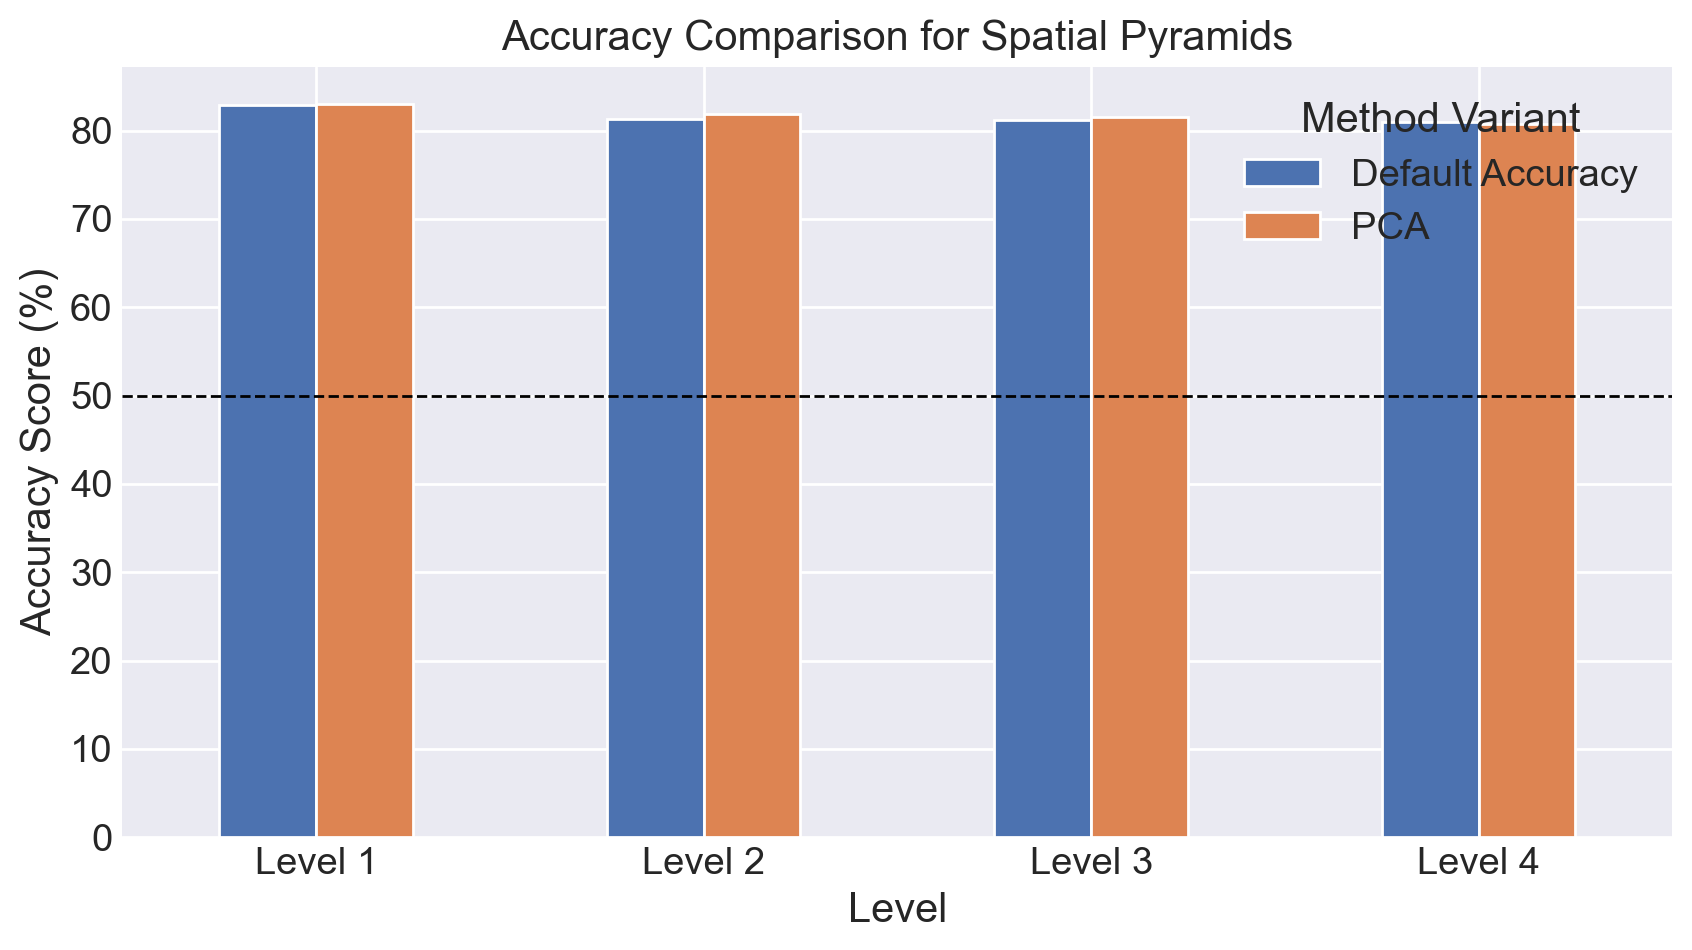

In [89]:
data = {
    'Level': ['Level 1', 'Level 2', 'Level 3', 'Level 4'],
    'Default Accuracy': [acc_level_1 ,acc_level_2, acc_level_3, acc_level_4],
    'PCA': [acc_level_1_pca, acc_level_2_pca, acc_level_3_pca, acc_level_4_pca]
}

accuracy_df = pd.DataFrame(data)
plt.style.use('seaborn-v0_8-darkgrid')
accuracy_df.set_index('Level').plot(kind='bar', figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)
plt.title('Accuracy Comparison for Spatial Pyramids')
plt.ylabel('Accuracy Score (%)')
plt.xlabel('Level')
plt.xticks(rotation=0)
plt.legend(loc='best', bbox_to_anchor=(0.5, 0.5))
plt.legend(title='Method Variant')
plt.show()

Surprisingly, the best results are obtained at level 1 where there is no zoning of the image. It could be that in our dataset the visual words are not always located in the same areas of the image and this method only introduces distortion.

### ROC Curve

We will make use of Dense SIFT and SVM classifier (fine-tuned). We have to modify our pipeline so that we can get the probability distribution of our predictions with `predict_proba`'s function on the sklearn library. Because we are in a multi-label scenario we will have to compute 7 ROC curves, one for each label class.


In [48]:

def pipeline_dense_sift_SVM_ROC(step_size, nfeatures=0, nOctaveLayers=3, k_codebook=128, k_neighbors=5, ker='linear'):
    # Compute descriptors train & test
    Detector_DENSE_SIFT = cv2.SIFT_create(nfeatures=nfeatures,nOctaveLayers=nOctaveLayers)
    Train_descriptors_DENSE_SIFT, Train_label_per_descriptor_DENSE_SIFT = compute_dense_descriptors(Detector_DENSE_SIFT, step_size)
    Test_descriptors_DENSE_SIFT, Test_label_per_descriptor_DENSE_SIFT = compute_dense_descriptors(Detector_DENSE_SIFT, step_size, test_images_filenames, test_labels)
        
    # Clustering (n_clusters = k) of the feature space
    k = k_codebook
    codebook_DENSE_SIFT = MiniBatchKMeans(n_init=3, n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook_DENSE_SIFT.fit(np.vstack(Train_descriptors_DENSE_SIFT))
    
    # BoVW train & test
    Train_visual_words_DENSE_SIFT = predict_BoVW(codebook_DENSE_SIFT, Train_descriptors_DENSE_SIFT, k_=k)
    Test_visual_words_DENSE_SIFT = predict_BoVW(codebook_DENSE_SIFT, Test_descriptors_DENSE_SIFT, k_=k)
    
    # PCA 109 components
    pca_ = PCA(n_components=109)
    Train_visual_words_DENSE_SIFT = pca_.fit_transform(Train_visual_words_DENSE_SIFT)
        
    # Classifier (SVM)
    model=svm.SVC(kernel=ker, probability=True)
    model.fit(Train_visual_words_DENSE_SIFT, train_labels) 
    
    # PCA 109 components
    Test_visual_words_DENSE_SIFT = pca_.transform(Test_visual_words_DENSE_SIFT)

    # Predicted
    predicted_probs = model.predict_proba(Test_visual_words_DENSE_SIFT)

    return predicted_probs


In [29]:
### Fine-tuned Dense SIFT and SVM hyper-parameters predicted probabilities
predicted_probs_DENSE_SVM_fine = pipeline_dense_sift_SVM_ROC(step_size=18, nfeatures=185, nOctaveLayers=2, k_codebook=198, k_neighbors=5, ker='rbf' )


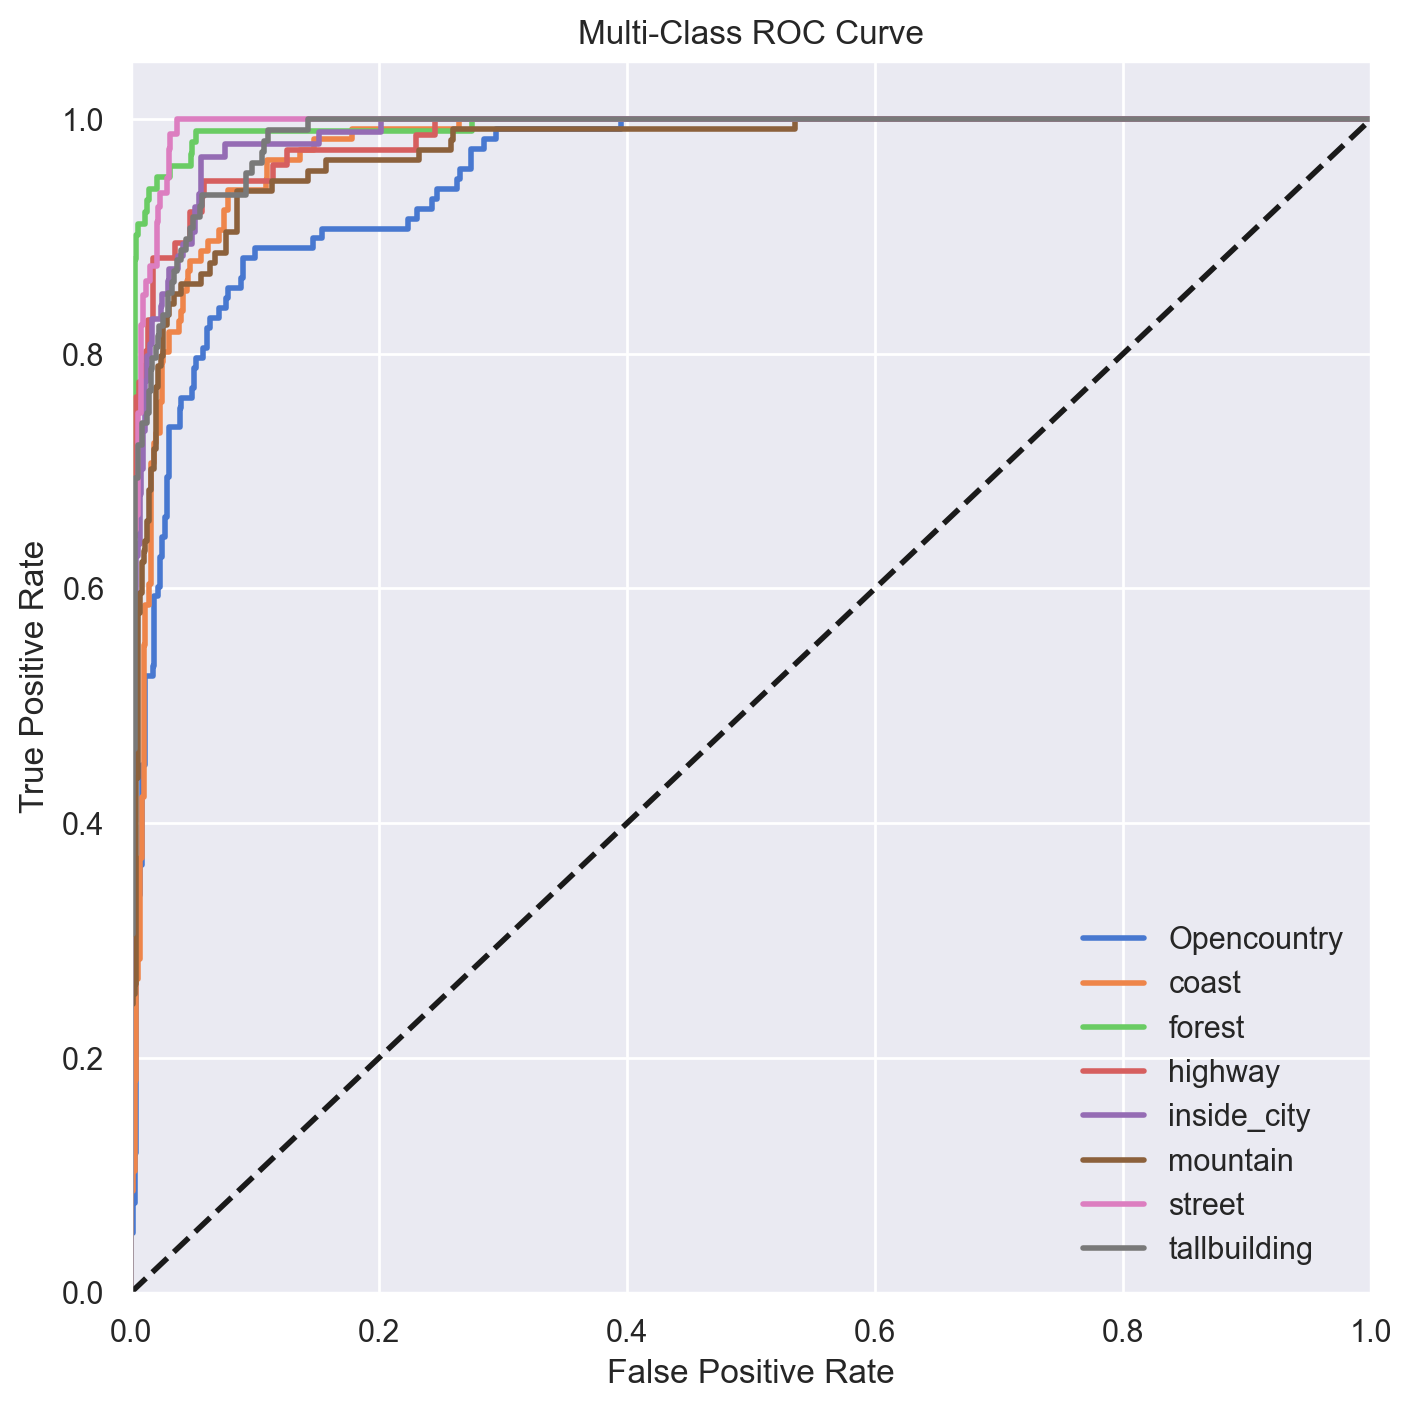

In [99]:

classes = np.unique(test_labels).tolist()
test_labels_binarized = label_binarize(test_labels, classes=classes)

fpr = dict()
tpr = dict()
avg = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], predicted_probs_DENSE_SVM_fine[:, i])
    avg[i] = average_precision_score(test_labels_binarized[:, i], predicted_probs_DENSE_SVM_fine[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Set the Seaborn style for a cleaner look
seaborn.set(style="darkgrid", palette="muted")
colors = seaborn.color_palette(n_colors=n_classes)
plt.figure(figsize=(8, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='{}'.format(classes[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right", frameon=False)
plt.show()

In [93]:
data = {
    'Class': ['Opencountry', 'coast', 'forest', 'highway', 'inside_city', 'mountain', 'street', 'tallbuilding'],
    'ROC AUC': np.around([roc_auc[0], roc_auc[1], roc_auc[2], roc_auc[3], roc_auc[4], roc_auc[5], roc_auc[6], roc_auc[7]], decimals=2)
}

roc_auc_df = pd.DataFrame(data)
roc_auc_df.index = [''] * len(roc_auc_df)
roc_auc_df

,Class,ROC AUC
,Opencountry,0.95
,coast,0.98
,forest,0.99
,highway,0.98
,inside_city,0.99
,mountain,0.97
,street,0.99
,tallbuilding,0.99


### Precision-Recall Curve

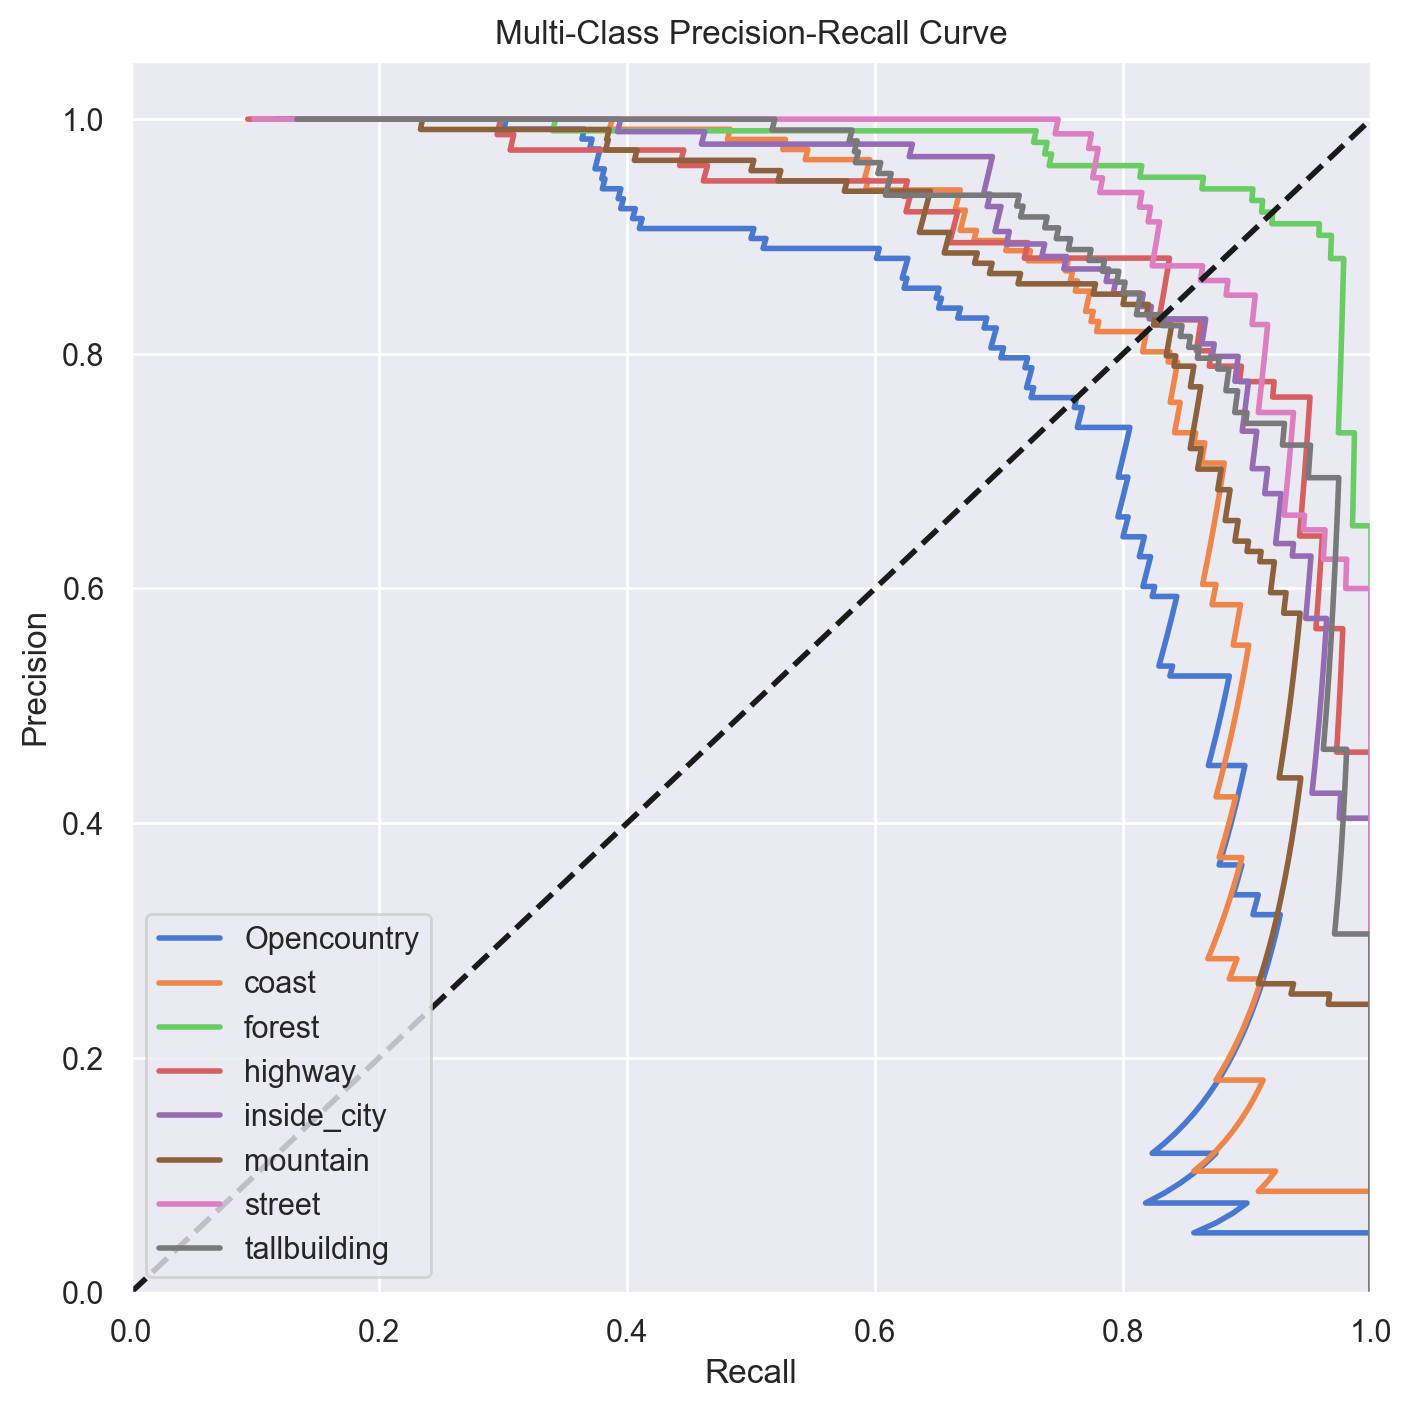

In [107]:

classes = np.unique(test_labels).tolist()
test_labels_binarized = label_binarize(test_labels, classes=classes)

recall = dict()
prec = dict()
avg = dict()
roc_auc = dict()
for i in range(len(classes)):
    recall[i], prec[i], _ = precision_recall_curve(test_labels_binarized[:, i], predicted_probs_DENSE_SVM_fine[:, i])
    avg[i] = average_precision_score(test_labels_binarized[:, i], predicted_probs_DENSE_SVM_fine[:, i])
    

# Set the Seaborn style for a cleaner look
seaborn.set(style="darkgrid", palette="muted")
colors = seaborn.color_palette(n_colors=n_classes)
plt.figure(figsize=(8, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], prec[i], color=color, lw=2, label='{}'.format(classes[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Multi-Class Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [108]:
data = {
    'Class': ['Opencountry', 'coast', 'forest', 'highway', 'inside_city', 'mountain', 'street', 'tallbuilding'],
    'Avg. Prec.': np.around([avg[0], avg[1], avg[2], avg[3], avg[4], avg[5], avg[6], avg[7]], decimals=2)
}

ap_df = pd.DataFrame(data)
ap_df.index = [''] * len(ap_df)
ap_df

,Class,Avg. Prec.
,Opencountry,0.79
,coast,0.85
,forest,0.97
,highway,0.92
,inside_city,0.92
,mountain,0.88
,street,0.95
,tallbuilding,0.92


# Fisher Vectors
Fisher Vectors [1] extend the Bag of Visual Words (BoVW) model by capturing more information about the distribution of the local descriptors, with the help of a Gaussian Mixture Model (GMM).

1. Extract local desc. (SIFT)
2. Fit a GMM model
3. Fisher Vectors
4. Normalization (optional)
5. SVM classification pipeline

[1] *Sánchez, J., Perronnin, F., Mensink, T. et al. Image Classification with the Fisher Vector: Theory and Practice. Int J Comput Vis 105, 222–245 (2013). https://doi.org/10.1007/s11263-013-0636-x*

In [109]:
# hyperparameters
step_size= 18
nfeatures = 185
nOctaveLayers = 2
k_codebook = 198
kernel='rbf'

# initialization
Detector_DENSE_SIFT = cv2.SIFT_create(nfeatures=nfeatures,nOctaveLayers=nOctaveLayers)

def compute_DENSE_SIFT_descriptors(images_filenames, labels, step_size=18):
    descriptors_DENSE_SIFT = []
    label_per_descriptor_DENSE_SIFT = []

    # compute descriptors for each image
    for filename,labels in zip(images_filenames,labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=Detector_DENSE_SIFT.compute(gray,kp)
        descriptors_DENSE_SIFT.append(des)
        label_per_descriptor_DENSE_SIFT.append(labels)
        
    return descriptors_DENSE_SIFT, label_per_descriptor_DENSE_SIFT

Train_descriptors_DENSE_SIFT, Train_label_per_descriptor_DENSE_SIFT = compute_DENSE_SIFT_descriptors(train_images_filenames, train_labels)
Test_descriptors_DENSE_SIFT, Test_label_per_descriptor_DENSE_SIFT = compute_DENSE_SIFT_descriptors(test_images_filenames, test_labels)


In [110]:
# train a GMM with SIFT raw descriptors
gmm = GaussianMixture(n_components=64, covariance_type='diag')
gmm.fit(np.vstack(Train_descriptors_DENSE_SIFT)) # (ONLY USING TRAIN SET!)


GaussianMixture(covariance_type='diag', n_components=64)

In [111]:
Train_descriptors_FISHER = []
for i in range(len(Train_descriptors_DENSE_SIFT)):
    fv_Train_feat = fv.fisher_vector(Train_descriptors_DENSE_SIFT[i], gmm)
    Train_descriptors_FISHER.append(fv_Train_feat)

Test_descriptors_FISHER = []
for i in range(len(Test_descriptors_DENSE_SIFT)):
    fv_Test_feat = fv.fisher_vector(Test_descriptors_DENSE_SIFT[i], gmm)
    Test_descriptors_FISHER.append(fv_Test_feat)

# once we have the fisher vectors, we can input them straight to a classifier
# there is no need to create the visual bag of words, as the fisher representation does this for us

model=svm.SVC(kernel='rbf')
model.fit(Train_descriptors_FISHER, Train_label_per_descriptor_DENSE_SIFT)

accuracy = 100*model.score(Test_descriptors_FISHER, Test_label_per_descriptor_DENSE_SIFT)
print("Fisher Vectors (GMM n_components = {}): {}".format(64, round(accuracy, 2)))


Fisher Vectors (GMM n_components = 64): 78.93


In [112]:
# PCA Normalization
PCA_ = PCA(n_components=109)
PCA_Fisher_Train = PCA_.fit_transform(np.vstack(Train_descriptors_FISHER))

model=svm.SVC(kernel=kernel)
model.fit(PCA_Fisher_Train.tolist(), Train_label_per_descriptor_DENSE_SIFT)

PCA_Fisher_Test = PCA_.transform(Test_descriptors_FISHER)
accuracy_PCA_FISHER = 100*model.score(PCA_Fisher_Test.tolist(), test_labels)
print("Fisher Vectors + PCA n_components = {} (GMM n_components = {}): {}".format(109, 64, round(accuracy_PCA_FISHER, 2)))

# LDA Normalization
LDA_ = LinearDiscriminantAnalysis(n_components=7)
LDA_Fisher_Train = LDA_.fit_transform(np.vstack(Train_descriptors_FISHER), train_labels)

model=svm.SVC(kernel=kernel)
model.fit(LDA_Fisher_Train.tolist(), Train_label_per_descriptor_DENSE_SIFT)

LDA_Fisher_Test = LDA_.transform(Test_descriptors_FISHER)
accuracy_LDA_FISHER = 100*model.score(LDA_Fisher_Test.tolist(), test_labels)
print("Fisher Vectors + LDA n_components = {} (GMM n_components = {}): {}".format(7, 64, round(accuracy_LDA_FISHER, 2)))


Fisher Vectors + PCA n_components = 69 (GMM n_components = 64): 79.43
Fisher Vectors + LDA n_components = 7 (GMM n_components = 64): 58.24


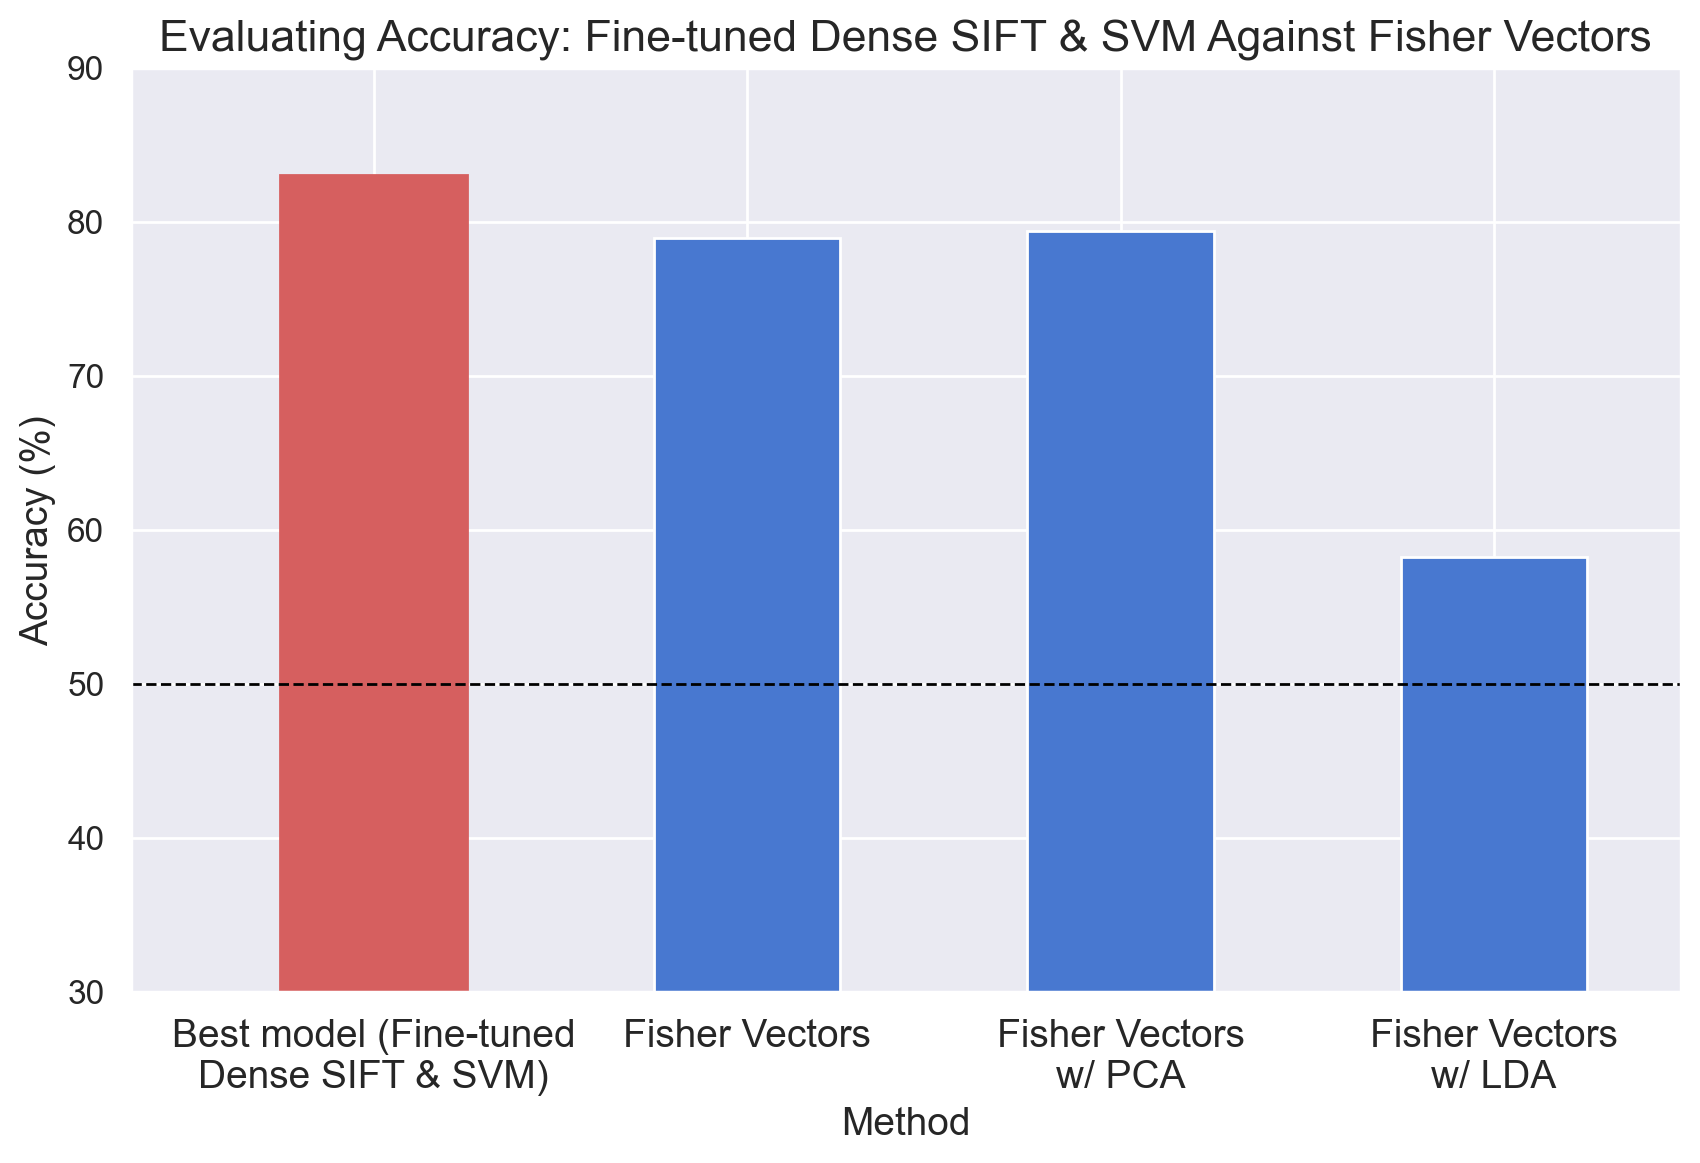

In [133]:
data = {
    'Best model (Fine-tuned\nDense SIFT & SVM)': 83.02,
    'Fisher Vectors': round(accuracy, 2),
    'Fisher Vectors\nw/ PCA': round(accuracy_PCA_FISHER, 2),
    'Fisher Vectors\nw/ LDA': round(accuracy_LDA_FISHER, 2),
}

accuracy_df = pd.DataFrame(list(data.items()), columns=['Method', 'Accuracy'])

plt.figure(figsize=(10, 6))
barlist = plt.bar(accuracy_df['Method'], accuracy_df['Accuracy'], width=0.5)
barlist[0].set_color('r')
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)
plt.title('Evaluating Accuracy: Fine-tuned Dense SIFT & SVM Against Fisher Vectors', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xlabel('Method', fontsize=14)
plt.ylim(30, 90)
plt.xlim(-0.65, len(accuracy_df['Method']) - 0.5)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=12)
plt.show()

### Results Visualization